In [1]:
import numpy as np
import csv
import pandas as pd

from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


def generate_csv(data, title, str_path):
    save_file = ""
    if(title == "actions"):
        save_file = str_path
    elif(title == "obs"):
        save_file = str_path
    
    np.savetxt(save_file, data, delimiter=",")
    all_filenames.append(save_file)
    
    with open(save_file,newline='') as f:
        r = csv.reader(f)
        row_data = [line for line in r]
        
    if(title == "actions"):
        with open(save_file,'w',newline='') as f:
            w = csv.writer(f)
            w.writerow(['act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                       'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                       'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                       'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
            
            w.writerows(row_data)
            return save_file
    elif(title == "obs"):
         with open(save_file,'w',newline='') as f:
            w = csv.writer(f)
            w.writerow(['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                        'drink_x', 'drink_y', 'drink_z',
                        'hand_x', 'hand_y', 'hand_z', 
                        'finger_lt0', 'finger_rg0', 'finger_md0',
                        'finger_if0', 'finger_if1', 'finger_if2',
                        'finger_tb0', 'finger_tb1', 'finger_tb2'])
            
            w.writerows(row_data)
            return save_file
            
def merge_csv(obs_path, action_path, save_path):

    a = pd.read_csv(obs_path)
    b = pd.read_csv(action_path)
    result = pd.concat([a, b], axis=1)
    result.to_csv(save_path, index=False)


Using TensorFlow backend.


In [2]:
def readTrain(file_path):
    train = pd.read_csv(file_path)
    print(train)
    print(train.shape)
    return train

def augDataRow(train, timestep):
    zero_row = train.loc[0]
    final_row = train.loc[train.shape[0]-1]
    df = pd.DataFrame([zero_row],columns=['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                                          'drink_x', 'drink_y', 'drink_z',
                                          'hand_x', 'hand_y', 'hand_z', 
                                          'finger_lt0', 'finger_rg0', 'finger_md0',
                                          'finger_if0', 'finger_if1', 'finger_if2',
                                          'finger_tb0', 'finger_tb1', 'finger_tb2',
                                          'act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                                          'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                                          'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                                          'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
                                          
    
    df_final = pd.DataFrame([final_row],columns=['arm_one', 'arm_two', 'arm_three', 'arm_four', 'arm_five', 'arm_six', 'arm_seven', 
                                                 'drink_x', 'drink_y', 'drink_z',
                                                 'hand_x', 'hand_y', 'hand_z', 
                                                 'finger_lt0', 'finger_rg0', 'finger_md0',
                                                 'finger_if0', 'finger_if1', 'finger_if2',
                                                 'finger_tb0', 'finger_tb1', 'finger_tb2',
                                                 'act_arm_one', 'act_arm_two', 'act_arm_three', 'act_arm_four', 'act_arm_five', 'act_arm_six', 'act_arm_seven',
                                                 'act_finger_lt0', 'act_finger_rg0', 'act_finger_md0',
                                                 'act_finger_if0', 'act_finger_if1', 'act_finger_if2',
                                                 'act_finger_tb0', 'act_finger_tb1', 'act_finger_tb2'])
    
    for i in range(timestep-1):
        train = pd.concat([df,train], ignore_index = True)
        
    for i in range(timestep-1):
        train = pd.concat([train,df_final], ignore_index = True)
        
    print(type(train))
    print(train.shape)   
    print(train)
    return train

hand_x_max_arr = []
hand_x_min_arr = []
hand_y_max_arr = []
hand_y_min_arr = []
hand_z_max_arr = []
hand_z_min_arr = []

def hand_pos(train):
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] > hand_x_max):
            hand_x_max = train['hand_x'][i]
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] < hand_x_min):
            hand_x_min = train['hand_x'][i]
    
    print("hand_x max is : " + str(hand_x_max))
    hand_x_max_arr.append(hand_x_max)
    print("hand_x min is : " + str(hand_x_min))
    hand_x_min_arr.append(hand_x_min)
    
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    for i in range(train['hand_y'].shape[0]):
#         print(train['hand_y'][i])
        if(train['hand_y'][i] > hand_y_max):
            hand_y_max = train['hand_y'][i]
    for i in range(train['hand_y'].shape[0]):
        if(train['hand_y'][i] < hand_y_min):
            hand_y_min = train['hand_y'][i]
    
    print("hand_y max is : " + str(hand_y_max))
    hand_y_max_arr.append(hand_y_max)
    print("hand_y min is : " + str(hand_y_min))
    hand_y_min_arr.append(hand_y_min)
    
     
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    for i in range(train['hand_z'].shape[0]):
#         print(train['hand_z'][i])
        if(train['hand_z'][i] > hand_z_max):
            hand_z_max = train['hand_z'][i]
    for i in range(train['hand_z'].shape[0]):
        if(train['hand_z'][i] < hand_z_min):
            hand_z_min = train['hand_z'][i]
    
    print("hand_z max is : " + str(hand_z_max))
    hand_z_max_arr.append(hand_z_max)
    print("hand_z min is : " + str(hand_z_min))
    hand_z_min_arr.append(hand_z_min)

###for many dataset
def many_normalize(train):
    max_x = 0.95
    min_x = 0.65
    max_z = 0.3
    min_z = 0.0
    
    train = train.drop(['drink_y'], axis=1)
    train['drink_x'] = (train['drink_x'] - min_x)/(max_x - min_x)
#    train['drink_y'] = (train['drink_y'] - train['drink_y'].min())/(train['drink_y'].max() - train['drink_y'].min())
    train['drink_z'] = (train['drink_z'] - min_z)/(max_z - min_z)
    
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    
    for i in range(len(hand_x_max_arr)):
        if(hand_x_max_arr[i] > hand_x_max):
            hand_x_max = hand_x_max_arr[i]
    for i in range(len(hand_x_min_arr)):
        if(hand_x_min_arr[i] < hand_x_min):
            hand_x_min = hand_x_min_arr[i]
            
    
    for i in range(len(hand_y_max_arr)):
        if(hand_y_max_arr[i] > hand_y_max):
            hand_y_max = hand_y_max_arr[i]
    for i in range(len(hand_y_min_arr)):
        if(hand_y_min_arr[i] < hand_y_min):
            hand_y_min = hand_y_min_arr[i]
            
    for i in range(len(hand_z_max_arr)):
        if(hand_z_max_arr[i] > hand_z_max):
            hand_z_max = hand_z_max_arr[i]
    for i in range(len(hand_z_min_arr)):
        if(hand_z_min_arr[i] < hand_z_min):
            hand_z_min = hand_z_min_arr[i]
            
    print("hand_x_max_arr is : " )
    print(hand_x_max_arr)
    print(hand_x_max)
    print("hand_x_min_arr is : " )
    print(hand_x_min_arr)
    print(hand_x_min)
    print("hand_y_max_arr is : " )
    print(hand_y_max_arr)
    print(hand_y_max)
    print("hand_y_min_arr is : " )
    print(hand_y_min_arr)
    print(hand_y_min)
    print("hand_z_max_arr is : " )
    print(hand_z_max_arr)
    print(hand_z_max)
    print("hand_z_min_arr is : " )
    print(hand_z_min_arr)
    print(hand_z_min)

    train['hand_x'] = (train['hand_x'] - hand_x_min)/(hand_x_max - hand_x_min)
    train['hand_y'] = (train['hand_y'] - hand_y_min)/(hand_y_max - hand_y_min)
    train['hand_z'] = (train['hand_z'] - hand_z_min)/(hand_z_max - hand_z_min)
     
    return train

"""
def DF_Col_Max_Min(train, column_name):
    
    max_value = -1000.0
    min_value = 1000.0
    
    for i in range(train[column_name].shape[0]):
        if(train[column_name][i] > max_value):
            max_value = train[column_name][i]
            
    for i in range(train[column_name].shape[0]):
        if(train[column_name][i] < min_value):
            min_value = train[column_name][i]
    
    return max_value, min_value
"""
###for one dataset
def normalize(train):
    #in dataset 0->8 : max_x = 0.9 min_x = 0.7 / max_y = min_y=0.82 / max_z = 0.25 min_z = 0.05 

    max_x = 0.95
    min_x = 0.65
    max_z = 0.3
    min_z = 0.0
    
    train = train.drop(['drink_y'], axis=1)
    train['drink_x'] = (train['drink_x'] - min_x)/(max_x - min_x)
#    train['drink_y'] = (train['drink_y'] - train['drink_y'].min())/(train['drink_y'].max() - train['drink_y'].min())
    train['drink_z'] = (train['drink_z'] - min_z)/(max_z - min_z)
    
    hand_x_max = -1000.0
    hand_x_min = 1000.0
    for i in range(train['hand_x'].shape[0]):
#         print(train['hand_x'][i])
        if(train['hand_x'][i] > hand_x_max):
            hand_x_max = train['hand_x'][i]
    for i in range(train['hand_x'].shape[0]):
        if(train['hand_x'][i] < hand_x_min):
            hand_x_min = train['hand_x'][i]
    
    print("hand_x max is : " + str(hand_x_max))
    print("hand_x min is : " + str(hand_x_min))
    
    hand_y_max = -1000.0
    hand_y_min = 1000.0
    for i in range(train['hand_y'].shape[0]):
#         print(train['hand_y'][i])
        if(train['hand_y'][i] > hand_y_max):
            hand_y_max = train['hand_y'][i]
    for i in range(train['hand_y'].shape[0]):
        if(train['hand_y'][i] < hand_y_min):
            hand_y_min = train['hand_y'][i]
    
    print("hand_y max is : " + str(hand_y_max))
    print("hand_y min is : " + str(hand_y_min))
    
    hand_z_max = -1000.0
    hand_z_min = 1000.0
    for i in range(train['hand_z'].shape[0]):
#         print(train['hand_z'][i])
        if(train['hand_z'][i] > hand_z_max):
            hand_z_max = train['hand_z'][i]
    for i in range(train['hand_z'].shape[0]):
        if(train['hand_z'][i] < hand_z_min):
            hand_z_min = train['hand_z'][i]
    
    print("hand_z max is : " + str(hand_z_max))
    print("hand_z min is : " + str(hand_z_min))

#     train['hand_x'] = (train['hand_x'] - train['hand_x'].min())/(train['hand_x'].max() - train['hand_x'].min())
#     train['hand_y'] = (train['hand_y'] - train['hand_y'].min())/(train['hand_y'].max() - train['hand_y'].min())
#     train['hand_z'] = (train['hand_z'] - train['hand_z'].min())/(train['hand_z'].max() - train['hand_z'].min())
      
    train['hand_x'] = (train['hand_x'] - hand_x_min)/(hand_x_max - hand_x_min)
    train['hand_y'] = (train['hand_y'] - hand_y_min)/(hand_y_max - hand_y_min)
    train['hand_z'] = (train['hand_z'] - hand_z_min)/(hand_z_max - hand_z_min)
     

    return train

def buildTrain_v2(train, timesteps):
    X_train, Y_train = [], []
    print(type(train))
    #original is 12 
    #plus 9 hand andgle
    train_split = np.split(train, [21], axis=1)
    X_train = train_split[0]
    Y_train = train_split[1]
    X_train_new = []
    Y_train_new = []
    
    print(Y_train)
    print(type(Y_train))
    print(Y_train.shape)
    
    timesteps = timesteps-1
    for i in range(train.shape[0] - timesteps):
#         print("now i is : " + str(i))
#         print(np.array(X_train.loc[i:i+timesteps]))
        X_train_new.append(np.array(X_train.loc[i:i+timesteps]))
    
    Y_train_new = np.array(Y_train.loc[0+timesteps:Y_train.shape[0]-1])   
              
    return np.array(X_train_new), Y_train_new


def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]


def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

def buildManyToOneModel(X_train):
    model = Sequential()
    ##many to many
    #model.add(LSTM(units = 64, return_sequences = True, input_shape = (1, X_train.shape[-1])))
    ##many to many
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

def buildManyToOneModel_expand_depth(X_train):
    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 32))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

def buildManyToOneModel_expand_depth_dropout(X_train):
    model = Sequential()
    model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]), recurrent_dropout = 0.2))
    model.add(LSTM(units = 64, return_sequences = True, recurrent_dropout = 0.2))
    model.add(LSTM(units = 32, recurrent_dropout = 0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model


##v2 represent add bidirectional & recurrent_ininlizer######
def buildManyToOneModel_expand_depth_dropout_V2(X_train):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 128, return_sequences = True, recurrent_initializer="orthogonal", input_shape = (X_train.shape[1], X_train.shape[2]), recurrent_dropout = 0.2)))
    model.add(Bidirectional(LSTM(units = 64, return_sequences = True, recurrent_initializer="orthogonal", recurrent_dropout = 0.2)))
    model.add(Bidirectional(LSTM(units = 32, recurrent_initializer="orthogonal", recurrent_dropout = 0.2)))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
#     model.summary()

    return model



def buildManyToOneModel_expand_depth_V2(X_train):
    model = Sequential()
    model.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
#     model.summary()

    return model



def buildManyToOneModel_expand_width(X_train):
    model = Sequential()
    ##many to many
    #model.add(LSTM(units = 64, return_sequences = True, input_shape = (1, X_train.shape[-1])))
    ##many to many
    model.add(LSTM(units = 1024, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 256))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16))
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    #rmsprop
    model.summary()

    return model

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            76800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/500
199/199 [==============================] -

199/199 [==============================] - 0s 677us/step - loss: 0.0013
Epoch 68/500
199/199 [==============================] - 0s 707us/step - loss: 0.0014
Epoch 69/500
199/199 [==============================] - 0s 667us/step - loss: 0.0016
Epoch 70/500
199/199 [==============================] - 0s 687us/step - loss: 0.0014
Epoch 71/500
199/199 [==============================] - 0s 707us/step - loss: 0.0019
Epoch 72/500
199/199 [==============================] - 0s 702us/step - loss: 0.0015
Epoch 73/500
199/199 [==============================] - 0s 727us/step - loss: 0.0026
Epoch 74/500
199/199 [==============================] - 0s 682us/step - loss: 0.0012
Epoch 75/500
199/199 [==============================] - 0s 662us/step - loss: 0.0015
Epoch 76/500
199/199 [==============================] - 0s 682us/step - loss: 0.0014
Epoch 77/500
199/199 [==============================] - 0s 692us/step - loss: 0.0011
Epoch 78/500
199/199 [==============================] - 0s 677us/step - loss: 

199/199 [==============================] - 0s 672us/step - loss: 7.8485e-04
Epoch 161/500
199/199 [==============================] - 0s 682us/step - loss: 6.9559e-04
Epoch 162/500
199/199 [==============================] - 0s 672us/step - loss: 7.6188e-04
Epoch 163/500
199/199 [==============================] - 0s 677us/step - loss: 7.4869e-04
Epoch 164/500
199/199 [==============================] - 0s 677us/step - loss: 4.6528e-04
Epoch 165/500
199/199 [==============================] - 0s 692us/step - loss: 8.5583e-04
Epoch 166/500
199/199 [==============================] - 0s 724us/step - loss: 7.1594e-04
Epoch 167/500
199/199 [==============================] - 0s 717us/step - loss: 4.3989e-04
Epoch 168/500
199/199 [==============================] - 0s 758us/step - loss: 6.4404e-04
Epoch 169/500
199/199 [==============================] - 0s 744us/step - loss: 8.6039e-04
Epoch 170/500
199/199 [==============================] - 0s 724us/step - loss: 3.9770e-04
Epoch 171/500
199/199 [=

199/199 [==============================] - 0s 677us/step - loss: 5.2494e-04
Epoch 252/500
199/199 [==============================] - 0s 684us/step - loss: 5.0520e-04
Epoch 253/500
199/199 [==============================] - 0s 697us/step - loss: 4.0722e-04
Epoch 254/500
199/199 [==============================] - 0s 682us/step - loss: 2.8242e-04
Epoch 255/500
199/199 [==============================] - 0s 687us/step - loss: 4.2830e-04
Epoch 256/500
199/199 [==============================] - 0s 672us/step - loss: 3.4681e-04
Epoch 257/500
199/199 [==============================] - 0s 717us/step - loss: 2.9676e-04
Epoch 258/500
199/199 [==============================] - 0s 697us/step - loss: 5.2544e-04
Epoch 259/500
199/199 [==============================] - 0s 712us/step - loss: 3.5833e-04
Epoch 260/500
199/199 [==============================] - 0s 682us/step - loss: 3.8814e-04
Epoch 261/500
199/199 [==============================] - 0s 687us/step - loss: 2.5986e-04
Epoch 262/500
199/199 [=

199/199 [==============================] - 0s 679us/step - loss: 3.6027e-04
Epoch 343/500
199/199 [==============================] - 0s 682us/step - loss: 1.7345e-04
Epoch 344/500
199/199 [==============================] - 0s 697us/step - loss: 2.5826e-04
Epoch 345/500
199/199 [==============================] - 0s 997us/step - loss: 2.8719e-04
Epoch 346/500
199/199 [==============================] - 0s 782us/step - loss: 2.8539e-04
Epoch 347/500
199/199 [==============================] - 0s 907us/step - loss: 2.1095e-04
Epoch 348/500
199/199 [==============================] - 0s 1ms/step - loss: 2.4265e-04
Epoch 349/500
199/199 [==============================] - 0s 1ms/step - loss: 2.4822e-04
Epoch 350/500
199/199 [==============================] - 0s 833us/step - loss: 3.5825e-04
Epoch 351/500
199/199 [==============================] - 0s 1ms/step - loss: 6.0139e-04
Epoch 352/500
199/199 [==============================] - 0s 1ms/step - loss: 1.8684e-04
Epoch 353/500
199/199 [=========

Epoch 433/500
199/199 [==============================] - 0s 782us/step - loss: 1.3524e-04
Epoch 434/500
199/199 [==============================] - 0s 1ms/step - loss: 2.0047e-04
Epoch 435/500
199/199 [==============================] - 0s 702us/step - loss: 1.8495e-04
Epoch 436/500
199/199 [==============================] - 0s 737us/step - loss: 1.9720e-04
Epoch 437/500
199/199 [==============================] - 0s 708us/step - loss: 1.3294e-04
Epoch 438/500
199/199 [==============================] - 0s 692us/step - loss: 1.5170e-04
Epoch 439/500
199/199 [==============================] - 0s 840us/step - loss: 1.9783e-04
Epoch 440/500
199/199 [==============================] - 0s 922us/step - loss: 2.1255e-04
Epoch 441/500
199/199 [==============================] - 0s 767us/step - loss: 2.1376e-04
Epoch 442/500
199/199 [==============================] - 0s 692us/step - loss: 2.7182e-04
Epoch 443/500
199/199 [==============================] - 0s 687us/step - loss: 1.3319e-04
Epoch 444/50

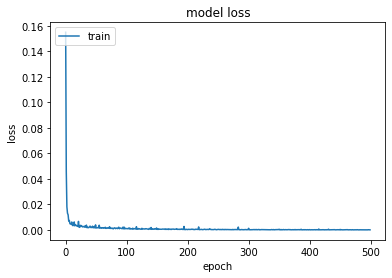

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 128)           76800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
204/204 [==============================] - 2s 12ms/step - loss: 0.1302
Epoch 2/500
204/204 [==============================] - 0s 1ms/step - loss: 0.0285
Epoch 3/500
204/204 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 4/500
204/204 [

204/204 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 90/500
204/204 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 91/500
204/204 [==============================] - 0s 1ms/step - loss: 9.1303e-04
Epoch 92/500
204/204 [==============================] - 0s 1ms/step - loss: 8.9588e-04
Epoch 93/500
204/204 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 94/500
204/204 [==============================] - 0s 1ms/step - loss: 8.2684e-04
Epoch 95/500
204/204 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 96/500
204/204 [==============================] - 0s 1ms/step - loss: 9.9844e-04
Epoch 97/500
204/204 [==============================] - 0s 1ms/step - loss: 7.2104e-04
Epoch 98/500
204/204 [==============================] - 0s 1ms/step - loss: 9.2897e-04
Epoch 99/500
204/204 [==============================] - 0s 1ms/step - loss: 8.5013e-04
Epoch 100/500
204/204 [==============================] - 0s 1ms/step - l

204/204 [==============================] - 0s 1ms/step - loss: 2.9644e-04
Epoch 183/500
204/204 [==============================] - 0s 1ms/step - loss: 5.1716e-04
Epoch 184/500
204/204 [==============================] - 0s 1ms/step - loss: 4.7797e-04
Epoch 185/500
204/204 [==============================] - 0s 1ms/step - loss: 3.4739e-04
Epoch 186/500
204/204 [==============================] - 0s 1ms/step - loss: 4.1905e-04
Epoch 187/500
204/204 [==============================] - 0s 1ms/step - loss: 5.1916e-04
Epoch 188/500
204/204 [==============================] - 0s 1ms/step - loss: 4.5298e-04
Epoch 189/500
204/204 [==============================] - 0s 2ms/step - loss: 3.2513e-04
Epoch 190/500
204/204 [==============================] - 0s 1ms/step - loss: 4.3831e-04
Epoch 191/500
204/204 [==============================] - 0s 1ms/step - loss: 3.4055e-04
Epoch 192/500
204/204 [==============================] - 0s 1ms/step - loss: 4.2556e-04
Epoch 193/500
204/204 [=======================

204/204 [==============================] - 0s 1ms/step - loss: 3.0519e-04
Epoch 276/500
204/204 [==============================] - 0s 1ms/step - loss: 2.1348e-04
Epoch 277/500
204/204 [==============================] - 0s 1ms/step - loss: 2.2807e-04
Epoch 278/500
204/204 [==============================] - 0s 1ms/step - loss: 1.7233e-04
Epoch 279/500
204/204 [==============================] - 0s 1ms/step - loss: 2.5892e-04
Epoch 280/500
204/204 [==============================] - 0s 1ms/step - loss: 3.5362e-04
Epoch 281/500
204/204 [==============================] - 0s 1ms/step - loss: 1.3762e-04
Epoch 282/500
204/204 [==============================] - 0s 1ms/step - loss: 2.1746e-04
Epoch 283/500
204/204 [==============================] - 0s 1ms/step - loss: 2.2775e-04
Epoch 284/500
204/204 [==============================] - 0s 1ms/step - loss: 3.3958e-04
Epoch 285/500
204/204 [==============================] - 0s 1ms/step - loss: 2.3473e-04
Epoch 286/500
204/204 [=======================

204/204 [==============================] - 0s 1ms/step - loss: 1.8983e-04
Epoch 369/500
204/204 [==============================] - 0s 1ms/step - loss: 2.0118e-04
Epoch 370/500
204/204 [==============================] - 0s 1ms/step - loss: 1.5893e-04
Epoch 371/500
204/204 [==============================] - 0s 1ms/step - loss: 1.8162e-04
Epoch 372/500
204/204 [==============================] - 0s 1ms/step - loss: 2.1231e-04
Epoch 373/500
204/204 [==============================] - 0s 1ms/step - loss: 1.9928e-04
Epoch 374/500
204/204 [==============================] - 0s 1ms/step - loss: 1.5620e-04
Epoch 375/500
204/204 [==============================] - 0s 1ms/step - loss: 2.0353e-04
Epoch 376/500
204/204 [==============================] - 0s 1ms/step - loss: 1.3353e-04
Epoch 377/500
204/204 [==============================] - 0s 1ms/step - loss: 1.4817e-04
Epoch 378/500
204/204 [==============================] - 0s 1ms/step - loss: 2.1390e-04
Epoch 379/500
204/204 [=======================

204/204 [==============================] - 0s 1ms/step - loss: 9.7861e-05
Epoch 462/500
204/204 [==============================] - 0s 1ms/step - loss: 1.8849e-04
Epoch 463/500
204/204 [==============================] - 0s 1ms/step - loss: 1.3078e-04
Epoch 464/500
204/204 [==============================] - 0s 1ms/step - loss: 1.4445e-04
Epoch 465/500
204/204 [==============================] - 0s 1ms/step - loss: 7.3905e-05
Epoch 466/500
204/204 [==============================] - 0s 1ms/step - loss: 1.5495e-04
Epoch 467/500
204/204 [==============================] - 0s 1ms/step - loss: 1.4547e-04
Epoch 468/500
204/204 [==============================] - 0s 1ms/step - loss: 1.7913e-04
Epoch 469/500
204/204 [==============================] - 0s 1ms/step - loss: 9.3025e-05
Epoch 470/500
204/204 [==============================] - 0s 1ms/step - loss: 1.5483e-04
Epoch 471/500
204/204 [==============================] - 0s 1ms/step - loss: 1.1421e-04
Epoch 472/500
204/204 [=======================

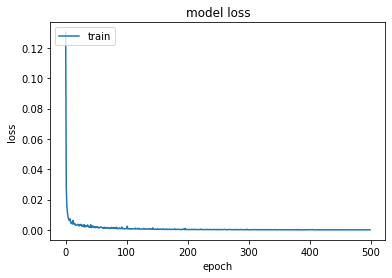

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 20, 128)           76800     
_________________________________________________________________
lstm_8 (LSTM)                (None, 20, 64)            49408     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
214/214 [==============================] - 3s 12ms/step - loss: 0.1196
Epoch 2/500
214/214 [==============================] - 0s 2ms/step - loss: 0.0337
Epoch 3/500
214/214 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 4/500
214/214 [

214/214 [==============================] - 0s 2ms/step - loss: 8.6600e-04
Epoch 89/500
214/214 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 90/500
214/214 [==============================] - 0s 2ms/step - loss: 7.4787e-04
Epoch 91/500
214/214 [==============================] - 0s 2ms/step - loss: 8.4495e-04
Epoch 92/500
214/214 [==============================] - 0s 2ms/step - loss: 8.4785e-04
Epoch 93/500
214/214 [==============================] - 0s 2ms/step - loss: 5.7539e-04
Epoch 94/500
214/214 [==============================] - 0s 2ms/step - loss: 6.9117e-04
Epoch 95/500
214/214 [==============================] - 0s 2ms/step - loss: 9.7967e-04
Epoch 96/500
214/214 [==============================] - 0s 2ms/step - loss: 6.3813e-04
Epoch 97/500
214/214 [==============================] - 0s 2ms/step - loss: 7.5246e-04
Epoch 98/500
214/214 [==============================] - 0s 2ms/step - loss: 9.1057e-04
Epoch 99/500
214/214 [==============================] - 0s 2

214/214 [==============================] - 0s 2ms/step - loss: 2.6242e-04
Epoch 182/500
214/214 [==============================] - 0s 2ms/step - loss: 3.3349e-04
Epoch 183/500
214/214 [==============================] - 0s 2ms/step - loss: 2.6149e-04
Epoch 184/500
214/214 [==============================] - 0s 2ms/step - loss: 3.0747e-04
Epoch 185/500
214/214 [==============================] - 0s 2ms/step - loss: 4.7830e-04
Epoch 186/500
214/214 [==============================] - 0s 2ms/step - loss: 2.8756e-04
Epoch 187/500
214/214 [==============================] - 0s 2ms/step - loss: 3.0894e-04
Epoch 188/500
214/214 [==============================] - 0s 2ms/step - loss: 2.5380e-04
Epoch 189/500
214/214 [==============================] - 0s 2ms/step - loss: 2.4298e-04
Epoch 190/500
214/214 [==============================] - 0s 2ms/step - loss: 3.1576e-04
Epoch 191/500
214/214 [==============================] - 0s 2ms/step - loss: 2.6191e-04
Epoch 192/500
214/214 [=======================

214/214 [==============================] - 0s 2ms/step - loss: 1.3314e-04
Epoch 275/500
214/214 [==============================] - 0s 2ms/step - loss: 2.6450e-04
Epoch 276/500
214/214 [==============================] - 0s 2ms/step - loss: 2.6087e-04
Epoch 277/500
214/214 [==============================] - 0s 2ms/step - loss: 1.9204e-04
Epoch 278/500
214/214 [==============================] - 0s 2ms/step - loss: 1.5048e-04
Epoch 279/500
214/214 [==============================] - 0s 2ms/step - loss: 1.4025e-04
Epoch 280/500
214/214 [==============================] - 0s 2ms/step - loss: 1.7241e-04
Epoch 281/500
214/214 [==============================] - 0s 2ms/step - loss: 2.3303e-04
Epoch 282/500
214/214 [==============================] - 0s 2ms/step - loss: 2.0795e-04
Epoch 283/500
214/214 [==============================] - 0s 2ms/step - loss: 1.7351e-04
Epoch 284/500
214/214 [==============================] - 0s 2ms/step - loss: 2.2940e-04
Epoch 285/500
214/214 [=======================

214/214 [==============================] - 0s 2ms/step - loss: 1.2485e-04
Epoch 368/500
214/214 [==============================] - 0s 2ms/step - loss: 1.4977e-04
Epoch 369/500
214/214 [==============================] - 0s 2ms/step - loss: 1.4349e-04
Epoch 370/500
214/214 [==============================] - 0s 2ms/step - loss: 1.6442e-04
Epoch 371/500
214/214 [==============================] - 0s 2ms/step - loss: 1.0666e-04
Epoch 372/500
214/214 [==============================] - 0s 2ms/step - loss: 1.1889e-04
Epoch 373/500
214/214 [==============================] - 0s 2ms/step - loss: 1.3375e-04
Epoch 374/500
214/214 [==============================] - 0s 2ms/step - loss: 1.8523e-04
Epoch 375/500
214/214 [==============================] - 0s 2ms/step - loss: 1.4180e-04
Epoch 376/500
214/214 [==============================] - 0s 2ms/step - loss: 1.0963e-04
Epoch 377/500
214/214 [==============================] - 0s 2ms/step - loss: 1.3936e-04
Epoch 378/500
214/214 [=======================

214/214 [==============================] - 0s 2ms/step - loss: 7.7498e-05
Epoch 461/500
214/214 [==============================] - 0s 2ms/step - loss: 1.0330e-04
Epoch 462/500
214/214 [==============================] - 0s 2ms/step - loss: 9.7160e-05
Epoch 463/500
214/214 [==============================] - 0s 2ms/step - loss: 1.1055e-04
Epoch 464/500
214/214 [==============================] - 0s 2ms/step - loss: 1.1160e-04
Epoch 465/500
214/214 [==============================] - 0s 2ms/step - loss: 8.8650e-05
Epoch 466/500
214/214 [==============================] - 0s 2ms/step - loss: 8.4822e-05
Epoch 467/500
214/214 [==============================] - 0s 2ms/step - loss: 1.4146e-04
Epoch 468/500
214/214 [==============================] - 0s 2ms/step - loss: 1.3841e-04
Epoch 469/500
214/214 [==============================] - 0s 2ms/step - loss: 7.4772e-05
Epoch 470/500
214/214 [==============================] - 0s 2ms/step - loss: 8.3021e-05
Epoch 471/500
214/214 [=======================

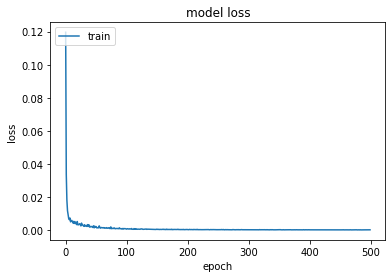

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30, 128)           76800     
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
224/224 [==============================] - 3s 14ms/step - loss: 0.1192
Epoch 2/500
224/224 [==============================] - 1s 3ms/step - loss: 0.0318
Epoch 3/500
224/224 [==============================] - 1s 3ms/step - loss: 0.0236
Epoch 4/500
224/224 [

224/224 [==============================] - 1s 3ms/step - loss: 7.4856e-04
Epoch 89/500
224/224 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 90/500
224/224 [==============================] - 1s 3ms/step - loss: 7.2995e-04
Epoch 91/500
224/224 [==============================] - 1s 3ms/step - loss: 7.1225e-04
Epoch 92/500
224/224 [==============================] - 1s 3ms/step - loss: 7.5561e-04
Epoch 93/500
224/224 [==============================] - 1s 3ms/step - loss: 5.5807e-04
Epoch 94/500
224/224 [==============================] - 1s 3ms/step - loss: 6.7282e-04
Epoch 95/500
224/224 [==============================] - 1s 3ms/step - loss: 8.8055e-04
Epoch 96/500
224/224 [==============================] - 1s 3ms/step - loss: 5.7058e-04
Epoch 97/500
224/224 [==============================] - 1s 3ms/step - loss: 6.9608e-04
Epoch 98/500
224/224 [==============================] - 1s 3ms/step - loss: 6.4904e-04
Epoch 99/500
224/224 [==============================] - 1s 3

224/224 [==============================] - 1s 3ms/step - loss: 2.2609e-04
Epoch 182/500
224/224 [==============================] - 1s 3ms/step - loss: 3.8106e-04
Epoch 183/500
224/224 [==============================] - 1s 3ms/step - loss: 2.1320e-04
Epoch 184/500
224/224 [==============================] - 1s 3ms/step - loss: 1.6217e-04
Epoch 185/500
224/224 [==============================] - 1s 3ms/step - loss: 2.5867e-04
Epoch 186/500
224/224 [==============================] - 1s 3ms/step - loss: 2.2103e-04
Epoch 187/500
224/224 [==============================] - 1s 3ms/step - loss: 2.2446e-04
Epoch 188/500
224/224 [==============================] - 1s 3ms/step - loss: 2.6654e-04
Epoch 189/500
224/224 [==============================] - 1s 3ms/step - loss: 2.7097e-04
Epoch 190/500
224/224 [==============================] - 1s 3ms/step - loss: 2.0406e-04
Epoch 191/500
224/224 [==============================] - 1s 3ms/step - loss: 2.1587e-04
Epoch 192/500
224/224 [=======================

224/224 [==============================] - 1s 3ms/step - loss: 1.5614e-04
Epoch 275/500
224/224 [==============================] - 1s 3ms/step - loss: 1.3720e-04
Epoch 276/500
224/224 [==============================] - 1s 3ms/step - loss: 1.6145e-04
Epoch 277/500
224/224 [==============================] - 1s 3ms/step - loss: 1.5281e-04
Epoch 278/500
224/224 [==============================] - 1s 3ms/step - loss: 1.3684e-04
Epoch 279/500
224/224 [==============================] - 1s 3ms/step - loss: 1.6356e-04
Epoch 280/500
224/224 [==============================] - 1s 3ms/step - loss: 1.5004e-04
Epoch 281/500
224/224 [==============================] - 1s 3ms/step - loss: 1.4471e-04
Epoch 282/500
224/224 [==============================] - 1s 3ms/step - loss: 1.5090e-04
Epoch 283/500
224/224 [==============================] - 1s 3ms/step - loss: 1.2710e-04
Epoch 284/500
224/224 [==============================] - 1s 3ms/step - loss: 1.4592e-04
Epoch 285/500
224/224 [=======================

224/224 [==============================] - 1s 3ms/step - loss: 1.2332e-04
Epoch 368/500
224/224 [==============================] - 1s 3ms/step - loss: 9.6112e-05
Epoch 369/500
224/224 [==============================] - 1s 3ms/step - loss: 6.6004e-05
Epoch 370/500
224/224 [==============================] - 1s 3ms/step - loss: 1.2163e-04
Epoch 371/500
224/224 [==============================] - 1s 3ms/step - loss: 1.2538e-04
Epoch 372/500
224/224 [==============================] - 1s 3ms/step - loss: 7.6602e-05
Epoch 373/500
224/224 [==============================] - 1s 3ms/step - loss: 1.4328e-04
Epoch 374/500
224/224 [==============================] - 1s 3ms/step - loss: 1.0484e-04
Epoch 375/500
224/224 [==============================] - 1s 3ms/step - loss: 1.2205e-04
Epoch 376/500
224/224 [==============================] - 1s 3ms/step - loss: 8.6009e-05
Epoch 377/500
224/224 [==============================] - 1s 3ms/step - loss: 9.2272e-05
Epoch 378/500
224/224 [=======================

224/224 [==============================] - 1s 3ms/step - loss: 9.1538e-05
Epoch 461/500
224/224 [==============================] - 1s 3ms/step - loss: 1.0294e-04
Epoch 462/500
224/224 [==============================] - 1s 3ms/step - loss: 7.1672e-05
Epoch 463/500
224/224 [==============================] - 1s 3ms/step - loss: 1.0129e-04
Epoch 464/500
224/224 [==============================] - 1s 3ms/step - loss: 7.5065e-05
Epoch 465/500
224/224 [==============================] - 1s 3ms/step - loss: 8.1640e-05
Epoch 466/500
224/224 [==============================] - 1s 3ms/step - loss: 1.0725e-04
Epoch 467/500
224/224 [==============================] - 1s 3ms/step - loss: 8.7656e-05
Epoch 468/500
224/224 [==============================] - 1s 3ms/step - loss: 5.7105e-05
Epoch 469/500
224/224 [==============================] - 1s 3ms/step - loss: 9.4764e-05
Epoch 470/500
224/224 [==============================] - 1s 3ms/step - loss: 8.5760e-05
Epoch 471/500
224/224 [=======================

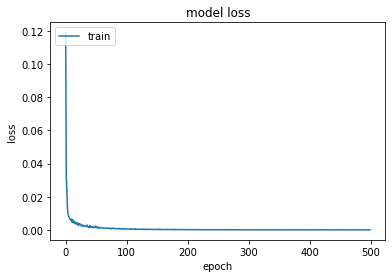

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 40, 128)           76800     
_________________________________________________________________
lstm_14 (LSTM)               (None, 40, 64)            49408     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
234/234 [==============================] - 3s 15ms/step - loss: 0.1019
Epoch 2/500
234/234 [==============================] - 1s 4ms/step - loss: 0.0269
Epoch 3/500
234/234 [==============================] - 1s 3ms/step - loss: 0.0195
Epoch 4/500
234/234 [

234/234 [==============================] - 1s 3ms/step - loss: 6.9480e-04
Epoch 89/500
234/234 [==============================] - 1s 3ms/step - loss: 6.8438e-04
Epoch 90/500
234/234 [==============================] - 1s 3ms/step - loss: 6.9818e-04
Epoch 91/500
234/234 [==============================] - 1s 3ms/step - loss: 7.4755e-04
Epoch 92/500
234/234 [==============================] - 1s 3ms/step - loss: 6.0322e-04
Epoch 93/500
234/234 [==============================] - 1s 3ms/step - loss: 5.7437e-04
Epoch 94/500
234/234 [==============================] - 1s 3ms/step - loss: 9.1314e-04
Epoch 95/500
234/234 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 96/500
234/234 [==============================] - 1s 3ms/step - loss: 5.8482e-04
Epoch 97/500
234/234 [==============================] - 1s 3ms/step - loss: 6.1538e-04
Epoch 98/500
234/234 [==============================] - 1s 3ms/step - loss: 6.8891e-04
Epoch 99/500
234/234 [==============================] - 1s 3

234/234 [==============================] - 1s 3ms/step - loss: 2.9893e-04
Epoch 182/500
234/234 [==============================] - 1s 3ms/step - loss: 2.1220e-04
Epoch 183/500
234/234 [==============================] - 1s 4ms/step - loss: 2.2606e-04
Epoch 184/500
234/234 [==============================] - 1s 3ms/step - loss: 2.2950e-04
Epoch 185/500
234/234 [==============================] - 1s 3ms/step - loss: 2.4634e-04
Epoch 186/500
234/234 [==============================] - 1s 3ms/step - loss: 3.3105e-04
Epoch 187/500
234/234 [==============================] - 1s 3ms/step - loss: 2.5028e-04
Epoch 188/500
234/234 [==============================] - 1s 3ms/step - loss: 2.2284e-04
Epoch 189/500
234/234 [==============================] - 1s 3ms/step - loss: 3.0825e-04
Epoch 190/500
234/234 [==============================] - 1s 3ms/step - loss: 2.6534e-04
Epoch 191/500
234/234 [==============================] - 1s 3ms/step - loss: 1.8053e-04
Epoch 192/500
234/234 [=======================

234/234 [==============================] - 1s 3ms/step - loss: 1.7033e-04
Epoch 275/500
234/234 [==============================] - 1s 3ms/step - loss: 1.5189e-04
Epoch 276/500
234/234 [==============================] - 1s 3ms/step - loss: 1.3893e-04
Epoch 277/500
234/234 [==============================] - 1s 3ms/step - loss: 1.3729e-04
Epoch 278/500
234/234 [==============================] - 1s 3ms/step - loss: 1.5169e-04
Epoch 279/500
234/234 [==============================] - 1s 3ms/step - loss: 1.6626e-04
Epoch 280/500
234/234 [==============================] - 1s 3ms/step - loss: 1.6380e-04
Epoch 281/500
234/234 [==============================] - 1s 3ms/step - loss: 2.0870e-04
Epoch 282/500
234/234 [==============================] - 1s 3ms/step - loss: 1.4044e-04
Epoch 283/500
234/234 [==============================] - 1s 3ms/step - loss: 1.5645e-04
Epoch 284/500
234/234 [==============================] - 1s 3ms/step - loss: 1.5356e-04
Epoch 285/500
234/234 [=======================

234/234 [==============================] - 1s 3ms/step - loss: 9.8454e-05
Epoch 368/500
234/234 [==============================] - 1s 3ms/step - loss: 1.3974e-04
Epoch 369/500
234/234 [==============================] - 1s 3ms/step - loss: 1.3911e-04
Epoch 370/500
234/234 [==============================] - 1s 3ms/step - loss: 1.2304e-04
Epoch 371/500
234/234 [==============================] - 1s 3ms/step - loss: 9.6512e-05
Epoch 372/500
234/234 [==============================] - 1s 3ms/step - loss: 1.1505e-04
Epoch 373/500
234/234 [==============================] - 1s 3ms/step - loss: 1.5880e-04
Epoch 374/500
234/234 [==============================] - 1s 3ms/step - loss: 1.1446e-04
Epoch 375/500
234/234 [==============================] - 1s 3ms/step - loss: 7.5308e-05
Epoch 376/500
234/234 [==============================] - 1s 3ms/step - loss: 9.3270e-05
Epoch 377/500
234/234 [==============================] - 1s 3ms/step - loss: 1.3874e-04
Epoch 378/500
234/234 [=======================

234/234 [==============================] - 1s 3ms/step - loss: 1.1229e-04
Epoch 461/500
234/234 [==============================] - 1s 3ms/step - loss: 9.0631e-05
Epoch 462/500
234/234 [==============================] - 1s 3ms/step - loss: 8.6956e-05
Epoch 463/500
234/234 [==============================] - 1s 3ms/step - loss: 1.0190e-04
Epoch 464/500
234/234 [==============================] - 1s 4ms/step - loss: 1.1499e-04
Epoch 465/500
234/234 [==============================] - 1s 3ms/step - loss: 7.5438e-05
Epoch 466/500
234/234 [==============================] - 1s 3ms/step - loss: 1.0461e-04
Epoch 467/500
234/234 [==============================] - 1s 3ms/step - loss: 7.6817e-05
Epoch 468/500
234/234 [==============================] - 1s 3ms/step - loss: 9.0976e-05
Epoch 469/500
234/234 [==============================] - 1s 3ms/step - loss: 1.1362e-04
Epoch 470/500
234/234 [==============================] - 1s 3ms/step - loss: 8.5072e-05
Epoch 471/500
234/234 [=======================

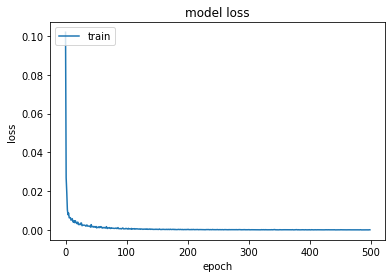

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 50, 128)           76800     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50, 64)            49408     
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
244/244 [==============================] - 4s 16ms/step - loss: 0.1203
Epoch 2/500
244/244 [==============================] - 1s 4ms/step - loss: 0.0336
Epoch 3/500
244/244 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 4/500
244/244 [

244/244 [==============================] - 1s 4ms/step - loss: 7.4637e-04
Epoch 89/500
244/244 [==============================] - 1s 4ms/step - loss: 5.8539e-04
Epoch 90/500
244/244 [==============================] - 1s 4ms/step - loss: 5.4483e-04
Epoch 91/500
244/244 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 92/500
244/244 [==============================] - 1s 5ms/step - loss: 6.9171e-04
Epoch 93/500
244/244 [==============================] - 1s 4ms/step - loss: 7.9835e-04
Epoch 94/500
244/244 [==============================] - 1s 4ms/step - loss: 8.5633e-04
Epoch 95/500
244/244 [==============================] - 1s 4ms/step - loss: 7.1530e-04
Epoch 96/500
244/244 [==============================] - 1s 4ms/step - loss: 5.5884e-04
Epoch 97/500
244/244 [==============================] - 1s 4ms/step - loss: 8.4475e-04
Epoch 98/500
244/244 [==============================] - 1s 4ms/step - loss: 6.4016e-04
Epoch 99/500
244/244 [==============================] - 1s 4

244/244 [==============================] - 1s 4ms/step - loss: 2.6348e-04
Epoch 182/500
244/244 [==============================] - 1s 4ms/step - loss: 3.2955e-04
Epoch 183/500
244/244 [==============================] - 1s 4ms/step - loss: 2.6215e-04
Epoch 184/500
244/244 [==============================] - 1s 4ms/step - loss: 3.4683e-04
Epoch 185/500
244/244 [==============================] - 1s 4ms/step - loss: 2.4898e-04
Epoch 186/500
244/244 [==============================] - 1s 4ms/step - loss: 3.0284e-04
Epoch 187/500
244/244 [==============================] - 1s 4ms/step - loss: 2.3318e-04
Epoch 188/500
244/244 [==============================] - 1s 4ms/step - loss: 2.3900e-04
Epoch 189/500
244/244 [==============================] - 1s 4ms/step - loss: 3.3609e-04
Epoch 190/500
244/244 [==============================] - 1s 4ms/step - loss: 2.4975e-04
Epoch 191/500
244/244 [==============================] - 1s 4ms/step - loss: 2.7368e-04
Epoch 192/500
244/244 [=======================

244/244 [==============================] - 1s 4ms/step - loss: 1.9294e-04
Epoch 275/500
244/244 [==============================] - 1s 4ms/step - loss: 1.9887e-04
Epoch 276/500
244/244 [==============================] - 1s 4ms/step - loss: 1.4878e-04
Epoch 277/500
244/244 [==============================] - 1s 4ms/step - loss: 1.3866e-04
Epoch 278/500
244/244 [==============================] - 1s 4ms/step - loss: 2.4649e-04
Epoch 279/500
244/244 [==============================] - 1s 4ms/step - loss: 1.0044e-04
Epoch 280/500
244/244 [==============================] - 1s 4ms/step - loss: 1.9498e-04
Epoch 281/500
244/244 [==============================] - 1s 5ms/step - loss: 1.7165e-04
Epoch 282/500
244/244 [==============================] - 1s 4ms/step - loss: 1.5362e-04
Epoch 283/500
244/244 [==============================] - 1s 4ms/step - loss: 1.4975e-04
Epoch 284/500
244/244 [==============================] - 1s 4ms/step - loss: 1.7206e-04
Epoch 285/500
244/244 [=======================

244/244 [==============================] - 1s 4ms/step - loss: 1.3478e-04
Epoch 368/500
244/244 [==============================] - 1s 4ms/step - loss: 1.0411e-04
Epoch 369/500
244/244 [==============================] - 1s 4ms/step - loss: 9.0496e-05
Epoch 370/500
244/244 [==============================] - 1s 4ms/step - loss: 1.1507e-04
Epoch 371/500
244/244 [==============================] - 1s 4ms/step - loss: 1.2486e-04
Epoch 372/500
244/244 [==============================] - 1s 4ms/step - loss: 1.2593e-04
Epoch 373/500
244/244 [==============================] - 1s 4ms/step - loss: 1.0559e-04
Epoch 374/500
244/244 [==============================] - 1s 4ms/step - loss: 1.0397e-04
Epoch 375/500
244/244 [==============================] - 1s 4ms/step - loss: 1.1483e-04
Epoch 376/500
244/244 [==============================] - 1s 5ms/step - loss: 1.4775e-04
Epoch 377/500
244/244 [==============================] - 1s 4ms/step - loss: 7.4056e-05
Epoch 378/500
244/244 [=======================

244/244 [==============================] - 1s 4ms/step - loss: 9.8048e-05
Epoch 461/500
244/244 [==============================] - 1s 4ms/step - loss: 1.0138e-04
Epoch 462/500
244/244 [==============================] - 1s 4ms/step - loss: 7.5912e-05
Epoch 463/500
244/244 [==============================] - 1s 4ms/step - loss: 8.9857e-05
Epoch 464/500
244/244 [==============================] - 1s 4ms/step - loss: 1.2057e-04
Epoch 465/500
244/244 [==============================] - 1s 4ms/step - loss: 8.2000e-05
Epoch 466/500
244/244 [==============================] - 1s 4ms/step - loss: 1.1110e-04
Epoch 467/500
244/244 [==============================] - 1s 4ms/step - loss: 5.8859e-05
Epoch 468/500
244/244 [==============================] - 1s 4ms/step - loss: 6.3772e-05
Epoch 469/500
244/244 [==============================] - 1s 4ms/step - loss: 1.1012e-04
Epoch 470/500
244/244 [==============================] - 1s 4ms/step - loss: 9.9924e-05
Epoch 471/500
244/244 [=======================

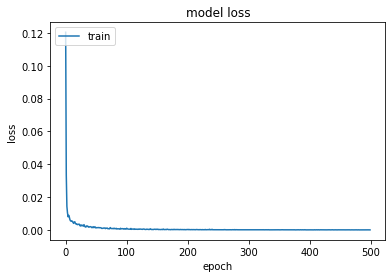

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 60, 128)           76800     
_________________________________________________________________
lstm_20 (LSTM)               (None, 60, 64)            49408     
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
254/254 [==============================] - 4s 17ms/step - loss: 0.1329
Epoch 2/500
254/254 [==============================] - 1s 5ms/step - loss: 0.0291
Epoch 3/500
254/254 [==============================] - 1s 5ms/step - loss: 0.0186
Epoch 4/500
254/254 [

254/254 [==============================] - 1s 5ms/step - loss: 7.3806e-04
Epoch 89/500
254/254 [==============================] - 1s 5ms/step - loss: 5.2423e-04
Epoch 90/500
254/254 [==============================] - 1s 5ms/step - loss: 9.1637e-04
Epoch 91/500
254/254 [==============================] - 1s 5ms/step - loss: 8.7447e-04
Epoch 92/500
254/254 [==============================] - 1s 5ms/step - loss: 6.9835e-04
Epoch 93/500
254/254 [==============================] - 1s 5ms/step - loss: 5.4283e-04
Epoch 94/500
254/254 [==============================] - 1s 5ms/step - loss: 0.0010
Epoch 95/500
254/254 [==============================] - 1s 5ms/step - loss: 4.5554e-04
Epoch 96/500
254/254 [==============================] - 1s 5ms/step - loss: 7.5115e-04
Epoch 97/500
254/254 [==============================] - 1s 5ms/step - loss: 6.2837e-04
Epoch 98/500
254/254 [==============================] - 1s 5ms/step - loss: 7.0846e-04
Epoch 99/500
254/254 [==============================] - 1s 5

254/254 [==============================] - 1s 5ms/step - loss: 3.4334e-04
Epoch 182/500
254/254 [==============================] - 1s 5ms/step - loss: 2.3199e-04
Epoch 183/500
254/254 [==============================] - 1s 5ms/step - loss: 3.7323e-04
Epoch 184/500
254/254 [==============================] - 1s 5ms/step - loss: 3.0347e-04
Epoch 185/500
254/254 [==============================] - 1s 5ms/step - loss: 2.4723e-04
Epoch 186/500
254/254 [==============================] - 1s 5ms/step - loss: 3.8855e-04
Epoch 187/500
254/254 [==============================] - 1s 5ms/step - loss: 2.5178e-04
Epoch 188/500
254/254 [==============================] - 1s 5ms/step - loss: 2.2913e-04
Epoch 189/500
254/254 [==============================] - 1s 5ms/step - loss: 2.2583e-04
Epoch 190/500
254/254 [==============================] - 1s 5ms/step - loss: 3.0110e-04
Epoch 191/500
254/254 [==============================] - 1s 5ms/step - loss: 2.5229e-04
Epoch 192/500
254/254 [=======================

254/254 [==============================] - 1s 5ms/step - loss: 2.1868e-04
Epoch 275/500
254/254 [==============================] - 1s 5ms/step - loss: 1.2882e-04
Epoch 276/500
254/254 [==============================] - 1s 5ms/step - loss: 1.2990e-04
Epoch 277/500
254/254 [==============================] - 1s 5ms/step - loss: 1.8537e-04
Epoch 278/500
254/254 [==============================] - 1s 5ms/step - loss: 1.6031e-04
Epoch 279/500
254/254 [==============================] - 1s 5ms/step - loss: 1.7809e-04
Epoch 280/500
254/254 [==============================] - 1s 5ms/step - loss: 2.4832e-04
Epoch 281/500
254/254 [==============================] - 1s 5ms/step - loss: 1.4158e-04
Epoch 282/500
254/254 [==============================] - 1s 5ms/step - loss: 1.5654e-04
Epoch 283/500
254/254 [==============================] - 1s 5ms/step - loss: 1.9825e-04
Epoch 284/500
254/254 [==============================] - 1s 5ms/step - loss: 1.9579e-04
Epoch 285/500
254/254 [=======================

254/254 [==============================] - 1s 5ms/step - loss: 1.2724e-04
Epoch 368/500
254/254 [==============================] - 1s 5ms/step - loss: 1.1408e-04
Epoch 369/500
254/254 [==============================] - 1s 5ms/step - loss: 1.1457e-04
Epoch 370/500
254/254 [==============================] - 1s 5ms/step - loss: 1.4693e-04
Epoch 371/500
254/254 [==============================] - 1s 5ms/step - loss: 1.6099e-04
Epoch 372/500
254/254 [==============================] - 1s 5ms/step - loss: 1.0672e-04
Epoch 373/500
254/254 [==============================] - 1s 5ms/step - loss: 1.7859e-04
Epoch 374/500
254/254 [==============================] - 1s 5ms/step - loss: 1.1039e-04
Epoch 375/500
254/254 [==============================] - 1s 5ms/step - loss: 9.3746e-05
Epoch 376/500
254/254 [==============================] - 1s 5ms/step - loss: 1.2594e-04
Epoch 377/500
254/254 [==============================] - 1s 5ms/step - loss: 1.4261e-04
Epoch 378/500
254/254 [=======================

254/254 [==============================] - 1s 5ms/step - loss: 7.7635e-05
Epoch 461/500
254/254 [==============================] - 1s 5ms/step - loss: 1.1266e-04
Epoch 462/500
254/254 [==============================] - 1s 5ms/step - loss: 1.7177e-04
Epoch 463/500
254/254 [==============================] - 1s 5ms/step - loss: 1.0900e-04
Epoch 464/500
254/254 [==============================] - 1s 5ms/step - loss: 9.9646e-05
Epoch 465/500
254/254 [==============================] - 1s 5ms/step - loss: 1.0469e-04
Epoch 466/500
254/254 [==============================] - 1s 5ms/step - loss: 1.1700e-04
Epoch 467/500
254/254 [==============================] - 1s 5ms/step - loss: 9.4936e-05
Epoch 468/500
254/254 [==============================] - 1s 5ms/step - loss: 1.3890e-04
Epoch 469/500
254/254 [==============================] - 1s 5ms/step - loss: 9.0082e-05
Epoch 470/500
254/254 [==============================] - 1s 5ms/step - loss: 8.8925e-05
Epoch 471/500
254/254 [=======================

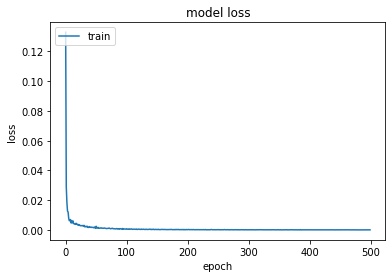

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

(264, 70, 21)
(264, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 70, 128)           76800     
_________________________________________________________________
lstm_23 (LSTM)               (None, 70, 64)            49408     
_________________________________________________________________
lstm_24 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
264/264 [==============================] - 5s 20ms/step - loss: 0.1332
Epoch 2/500
264/264 [==============================] - 2s 7ms/step - loss: 0.0336
Epoch 3/500
264/264 [==============================] - 2s 7ms/step - loss: 0.01

264/264 [==============================] - 2s 7ms/step - loss: 7.6208e-04
Epoch 88/500
264/264 [==============================] - 2s 7ms/step - loss: 6.4045e-04
Epoch 89/500
264/264 [==============================] - 2s 7ms/step - loss: 7.1463e-04
Epoch 90/500
264/264 [==============================] - 2s 7ms/step - loss: 7.2231e-04
Epoch 91/500
264/264 [==============================] - 2s 7ms/step - loss: 3.4780e-04
Epoch 92/500
264/264 [==============================] - 2s 7ms/step - loss: 7.1512e-04
Epoch 93/500
264/264 [==============================] - 2s 7ms/step - loss: 6.0722e-04
Epoch 94/500
264/264 [==============================] - 2s 7ms/step - loss: 6.5210e-04
Epoch 95/500
264/264 [==============================] - 2s 7ms/step - loss: 6.7328e-04
Epoch 96/500
264/264 [==============================] - 2s 7ms/step - loss: 6.5798e-04
Epoch 97/500
264/264 [==============================] - 2s 7ms/step - loss: 9.4155e-04
Epoch 98/500
264/264 [==============================] - 

264/264 [==============================] - 2s 7ms/step - loss: 3.1844e-04
Epoch 181/500
264/264 [==============================] - 2s 7ms/step - loss: 1.8632e-04
Epoch 182/500
264/264 [==============================] - 2s 7ms/step - loss: 2.1734e-04
Epoch 183/500
264/264 [==============================] - 2s 7ms/step - loss: 2.4346e-04
Epoch 184/500
264/264 [==============================] - 2s 7ms/step - loss: 2.6754e-04
Epoch 185/500
264/264 [==============================] - 2s 7ms/step - loss: 2.2242e-04
Epoch 186/500
264/264 [==============================] - 2s 7ms/step - loss: 2.7289e-04
Epoch 187/500
264/264 [==============================] - 2s 7ms/step - loss: 3.6188e-04
Epoch 188/500
264/264 [==============================] - 2s 7ms/step - loss: 3.0317e-04
Epoch 189/500
264/264 [==============================] - 2s 7ms/step - loss: 2.2205e-04
Epoch 190/500
264/264 [==============================] - 2s 7ms/step - loss: 2.5928e-04
Epoch 191/500
264/264 [=======================

264/264 [==============================] - 2s 7ms/step - loss: 1.4482e-04
Epoch 274/500
264/264 [==============================] - 2s 7ms/step - loss: 1.8301e-04
Epoch 275/500
264/264 [==============================] - 2s 7ms/step - loss: 1.3998e-04
Epoch 276/500
264/264 [==============================] - 2s 7ms/step - loss: 1.4032e-04
Epoch 277/500
264/264 [==============================] - 2s 7ms/step - loss: 2.0022e-04
Epoch 278/500
264/264 [==============================] - 2s 7ms/step - loss: 2.5918e-04
Epoch 279/500
264/264 [==============================] - 2s 7ms/step - loss: 1.9450e-04
Epoch 280/500
264/264 [==============================] - 2s 7ms/step - loss: 1.0025e-04
Epoch 281/500
264/264 [==============================] - 2s 7ms/step - loss: 2.0993e-04
Epoch 282/500
264/264 [==============================] - 2s 7ms/step - loss: 1.0653e-04
Epoch 283/500
264/264 [==============================] - 2s 7ms/step - loss: 1.9756e-04
Epoch 284/500
264/264 [=======================

264/264 [==============================] - 2s 7ms/step - loss: 1.0227e-04
Epoch 367/500
264/264 [==============================] - 2s 7ms/step - loss: 1.0962e-04
Epoch 368/500
264/264 [==============================] - 2s 7ms/step - loss: 1.1949e-04
Epoch 369/500
264/264 [==============================] - 2s 7ms/step - loss: 1.3558e-04
Epoch 370/500
264/264 [==============================] - 2s 7ms/step - loss: 1.0056e-04
Epoch 371/500
264/264 [==============================] - 2s 7ms/step - loss: 9.6569e-05
Epoch 372/500
264/264 [==============================] - 2s 7ms/step - loss: 1.4098e-04
Epoch 373/500
264/264 [==============================] - 2s 7ms/step - loss: 1.0792e-04
Epoch 374/500
264/264 [==============================] - 2s 7ms/step - loss: 1.2971e-04
Epoch 375/500
264/264 [==============================] - 2s 7ms/step - loss: 1.5054e-04
Epoch 376/500
264/264 [==============================] - 2s 7ms/step - loss: 1.2463e-04
Epoch 377/500
264/264 [=======================

264/264 [==============================] - 2s 7ms/step - loss: 1.0195e-04
Epoch 460/500
264/264 [==============================] - 2s 7ms/step - loss: 8.9277e-05
Epoch 461/500
264/264 [==============================] - 2s 7ms/step - loss: 1.2467e-04
Epoch 462/500
264/264 [==============================] - 2s 7ms/step - loss: 1.2952e-04
Epoch 463/500
264/264 [==============================] - 2s 7ms/step - loss: 8.3686e-05
Epoch 464/500
264/264 [==============================] - 2s 7ms/step - loss: 7.4444e-05
Epoch 465/500
264/264 [==============================] - 2s 7ms/step - loss: 8.5272e-05
Epoch 466/500
264/264 [==============================] - 2s 7ms/step - loss: 9.3006e-05
Epoch 467/500
264/264 [==============================] - 2s 7ms/step - loss: 1.0293e-04
Epoch 468/500
264/264 [==============================] - 2s 7ms/step - loss: 6.5987e-05
Epoch 469/500
264/264 [==============================] - 2s 7ms/step - loss: 1.2626e-04
Epoch 470/500
264/264 [=======================

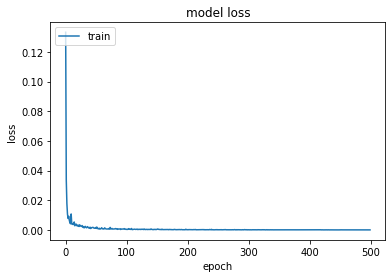

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

(274, 80, 21)
(274, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 80, 128)           76800     
_________________________________________________________________
lstm_26 (LSTM)               (None, 80, 64)            49408     
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
274/274 [==============================] - 6s 22ms/step - loss: 0.1052
Epoch 2/500
274/274 [==============================] - 2s 8ms/step - loss: 0.0212
Epoch 3/500
274/274 [==============================] - 2s 8ms/step - loss: 0.01

274/274 [==============================] - 2s 7ms/step - loss: 4.4483e-04
Epoch 88/500
274/274 [==============================] - 2s 8ms/step - loss: 7.6939e-04
Epoch 89/500
274/274 [==============================] - 2s 8ms/step - loss: 3.6449e-04
Epoch 90/500
274/274 [==============================] - 2s 7ms/step - loss: 3.2309e-04
Epoch 91/500
274/274 [==============================] - 2s 8ms/step - loss: 5.0758e-04
Epoch 92/500
274/274 [==============================] - 2s 8ms/step - loss: 6.0409e-04
Epoch 93/500
274/274 [==============================] - 2s 8ms/step - loss: 3.5768e-04
Epoch 94/500
274/274 [==============================] - 2s 8ms/step - loss: 4.3777e-04
Epoch 95/500
274/274 [==============================] - 2s 7ms/step - loss: 6.7362e-04
Epoch 96/500
274/274 [==============================] - 2s 8ms/step - loss: 3.1514e-04
Epoch 97/500
274/274 [==============================] - 2s 7ms/step - loss: 3.9497e-04
Epoch 98/500
274/274 [==============================] - 

274/274 [==============================] - 2s 7ms/step - loss: 3.4005e-04
Epoch 181/500
274/274 [==============================] - 2s 8ms/step - loss: 1.8465e-04
Epoch 182/500
274/274 [==============================] - 2s 8ms/step - loss: 1.7887e-04
Epoch 183/500
274/274 [==============================] - 2s 8ms/step - loss: 2.8628e-04
Epoch 184/500
274/274 [==============================] - 2s 7ms/step - loss: 2.9236e-04
Epoch 185/500
274/274 [==============================] - 2s 8ms/step - loss: 2.5673e-04
Epoch 186/500
274/274 [==============================] - 2s 8ms/step - loss: 3.1400e-04
Epoch 187/500
274/274 [==============================] - 2s 7ms/step - loss: 2.1193e-04
Epoch 188/500
274/274 [==============================] - 2s 8ms/step - loss: 1.6049e-04
Epoch 189/500
274/274 [==============================] - 2s 8ms/step - loss: 1.8992e-04
Epoch 190/500
274/274 [==============================] - 2s 8ms/step - loss: 3.1039e-04
Epoch 191/500
274/274 [=======================

274/274 [==============================] - 2s 8ms/step - loss: 1.2437e-04
Epoch 274/500
274/274 [==============================] - 2s 8ms/step - loss: 8.1566e-05
Epoch 275/500
274/274 [==============================] - 2s 8ms/step - loss: 8.5832e-05
Epoch 276/500
274/274 [==============================] - 2s 8ms/step - loss: 1.1971e-04
Epoch 277/500
274/274 [==============================] - 2s 8ms/step - loss: 1.6764e-04
Epoch 278/500
274/274 [==============================] - 2s 8ms/step - loss: 9.9447e-05
Epoch 279/500
274/274 [==============================] - 2s 8ms/step - loss: 1.4721e-04
Epoch 280/500
274/274 [==============================] - 2s 7ms/step - loss: 6.9095e-05
Epoch 281/500
274/274 [==============================] - 2s 7ms/step - loss: 1.6833e-04
Epoch 282/500
274/274 [==============================] - 2s 7ms/step - loss: 1.4312e-04
Epoch 283/500
274/274 [==============================] - 2s 8ms/step - loss: 1.1473e-04
Epoch 284/500
274/274 [=======================

274/274 [==============================] - 2s 8ms/step - loss: 6.4868e-05
Epoch 367/500
274/274 [==============================] - 2s 7ms/step - loss: 1.6309e-04
Epoch 368/500
274/274 [==============================] - 2s 7ms/step - loss: 7.3986e-05
Epoch 369/500
274/274 [==============================] - 2s 8ms/step - loss: 8.3756e-05
Epoch 370/500
274/274 [==============================] - 2s 8ms/step - loss: 7.8738e-05
Epoch 371/500
274/274 [==============================] - 2s 8ms/step - loss: 1.1159e-04
Epoch 372/500
274/274 [==============================] - 2s 7ms/step - loss: 6.6311e-05
Epoch 373/500
274/274 [==============================] - 2s 8ms/step - loss: 1.0157e-04
Epoch 374/500
274/274 [==============================] - 2s 7ms/step - loss: 7.2208e-05
Epoch 375/500
274/274 [==============================] - 2s 8ms/step - loss: 1.0993e-04
Epoch 376/500
274/274 [==============================] - 2s 8ms/step - loss: 7.5275e-05
Epoch 377/500
274/274 [=======================

274/274 [==============================] - 2s 7ms/step - loss: 7.2897e-05
Epoch 460/500
274/274 [==============================] - 2s 8ms/step - loss: 8.3249e-05
Epoch 461/500
274/274 [==============================] - 2s 8ms/step - loss: 9.2280e-05
Epoch 462/500
274/274 [==============================] - 2s 8ms/step - loss: 4.9635e-05
Epoch 463/500
274/274 [==============================] - 2s 8ms/step - loss: 7.1641e-05
Epoch 464/500
274/274 [==============================] - 2s 8ms/step - loss: 5.8176e-05
Epoch 465/500
274/274 [==============================] - 2s 8ms/step - loss: 7.1366e-05
Epoch 466/500
274/274 [==============================] - 2s 8ms/step - loss: 8.8672e-05
Epoch 467/500
274/274 [==============================] - 2s 7ms/step - loss: 5.2295e-05
Epoch 468/500
274/274 [==============================] - 2s 8ms/step - loss: 6.5531e-05
Epoch 469/500
274/274 [==============================] - 2s 8ms/step - loss: 6.3365e-05
Epoch 470/500
274/274 [=======================

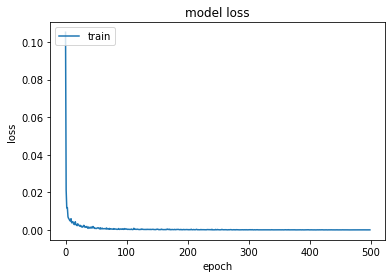

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

[373 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
(373, 16)
(284, 90, 21)
(284, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 90, 128)           76800     
_________________________________________________________________
lstm_29 (LSTM)               (None, 90, 64)            49408     
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
284/284 [==============================] - 6s 23ms/step - loss: 0.0950
Epoch 2/500
284/284 [==============================] - 2s 8ms/step - loss: 0.0179
Epoch 3

284/284 [==============================] - 2s 8ms/step - loss: 5.7627e-04
Epoch 87/500
284/284 [==============================] - 2s 8ms/step - loss: 5.8675e-04
Epoch 88/500
284/284 [==============================] - 2s 8ms/step - loss: 4.9792e-04
Epoch 89/500
284/284 [==============================] - 2s 8ms/step - loss: 4.8923e-04
Epoch 90/500
284/284 [==============================] - 2s 8ms/step - loss: 4.6747e-04
Epoch 91/500
284/284 [==============================] - 2s 8ms/step - loss: 4.6708e-04
Epoch 92/500
284/284 [==============================] - 2s 9ms/step - loss: 5.6812e-04
Epoch 93/500
284/284 [==============================] - 2s 8ms/step - loss: 6.0572e-04
Epoch 94/500
284/284 [==============================] - 2s 8ms/step - loss: 5.2209e-04
Epoch 95/500
284/284 [==============================] - 2s 8ms/step - loss: 6.0209e-04
Epoch 96/500
284/284 [==============================] - 2s 8ms/step - loss: 3.4911e-04
Epoch 97/500
284/284 [==============================] - 

284/284 [==============================] - 2s 8ms/step - loss: 2.0515e-04
Epoch 180/500
284/284 [==============================] - 2s 8ms/step - loss: 1.7351e-04
Epoch 181/500
284/284 [==============================] - 2s 8ms/step - loss: 2.1315e-04
Epoch 182/500
284/284 [==============================] - 3s 9ms/step - loss: 1.5685e-04
Epoch 183/500
284/284 [==============================] - 2s 8ms/step - loss: 1.8793e-04
Epoch 184/500
284/284 [==============================] - 2s 8ms/step - loss: 2.2027e-04
Epoch 185/500
284/284 [==============================] - 2s 8ms/step - loss: 1.6703e-04
Epoch 186/500
284/284 [==============================] - 2s 8ms/step - loss: 1.9251e-04
Epoch 187/500
284/284 [==============================] - 2s 8ms/step - loss: 1.5498e-04
Epoch 188/500
284/284 [==============================] - 2s 8ms/step - loss: 2.3588e-04
Epoch 189/500
284/284 [==============================] - 2s 9ms/step - loss: 2.9906e-04
Epoch 190/500
284/284 [=======================

284/284 [==============================] - 2s 8ms/step - loss: 1.0124e-04
Epoch 273/500
284/284 [==============================] - 2s 8ms/step - loss: 1.5150e-04
Epoch 274/500
284/284 [==============================] - 2s 8ms/step - loss: 1.0883e-04
Epoch 275/500
284/284 [==============================] - 2s 8ms/step - loss: 1.3434e-04
Epoch 276/500
284/284 [==============================] - 2s 8ms/step - loss: 9.2831e-05
Epoch 277/500
284/284 [==============================] - 2s 8ms/step - loss: 1.2448e-04
Epoch 278/500
284/284 [==============================] - 2s 8ms/step - loss: 1.0497e-04
Epoch 279/500
284/284 [==============================] - 2s 8ms/step - loss: 1.4284e-04
Epoch 280/500
284/284 [==============================] - 2s 8ms/step - loss: 7.2849e-05
Epoch 281/500
284/284 [==============================] - 2s 8ms/step - loss: 1.1503e-04
Epoch 282/500
284/284 [==============================] - 2s 8ms/step - loss: 1.4143e-04
Epoch 283/500
284/284 [=======================

284/284 [==============================] - 2s 8ms/step - loss: 7.1670e-05
Epoch 366/500
284/284 [==============================] - 2s 8ms/step - loss: 9.4344e-05
Epoch 367/500
284/284 [==============================] - 2s 8ms/step - loss: 9.8043e-05
Epoch 368/500
284/284 [==============================] - 2s 8ms/step - loss: 6.6566e-05
Epoch 369/500
284/284 [==============================] - 2s 8ms/step - loss: 1.0181e-04
Epoch 370/500
284/284 [==============================] - 2s 8ms/step - loss: 6.9206e-05
Epoch 371/500
284/284 [==============================] - 2s 8ms/step - loss: 1.0119e-04
Epoch 372/500
284/284 [==============================] - 2s 8ms/step - loss: 8.7801e-05
Epoch 373/500
284/284 [==============================] - 2s 8ms/step - loss: 8.7906e-05
Epoch 374/500
284/284 [==============================] - 2s 8ms/step - loss: 8.4663e-05
Epoch 375/500
284/284 [==============================] - 2s 9ms/step - loss: 1.1115e-04
Epoch 376/500
284/284 [=======================

284/284 [==============================] - 2s 8ms/step - loss: 5.0120e-05
Epoch 459/500
284/284 [==============================] - 2s 8ms/step - loss: 7.5169e-05
Epoch 460/500
284/284 [==============================] - 2s 8ms/step - loss: 8.1719e-05
Epoch 461/500
284/284 [==============================] - 2s 8ms/step - loss: 5.7098e-05
Epoch 462/500
284/284 [==============================] - 2s 8ms/step - loss: 8.1992e-05
Epoch 463/500
284/284 [==============================] - 2s 8ms/step - loss: 6.1425e-05
Epoch 464/500
284/284 [==============================] - 2s 9ms/step - loss: 5.4044e-05
Epoch 465/500
284/284 [==============================] - 2s 8ms/step - loss: 6.8446e-05
Epoch 466/500
284/284 [==============================] - 2s 8ms/step - loss: 8.1375e-05
Epoch 467/500
284/284 [==============================] - 2s 8ms/step - loss: 6.5201e-05
Epoch 468/500
284/284 [==============================] - 2s 8ms/step - loss: 4.9605e-05
Epoch 469/500
284/284 [=======================

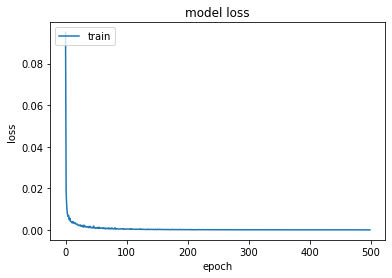

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

[393 rows x 37 columns]
~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
     act_arm_one  act_arm_two  act_arm_three  act_arm_four  act_arm_five  \
0       0.743188     0.498898       0.497298      0.020865       0.50605   
1       0.743188     0.498898       0.497298      0.020865       0.50605   
2       0.743188     0.498898       0.497298      0.020865       0.50605   
3       0.743188     0.498898       0.497298      0.020865       0.50605   
4       0.743188     0.498898       0.497298      0.020865       0.50605   
5       0.743188     0.498898       0.497298      0.020865       0.50605   
6       0.743188     0.498898       0.497298      0.020865       0.50605   
7       0.743188     0.498898       0.497298      0.020865       0.50605   
8       0.743188     0.498898       0.497298      0.020865       0.50605   
9       0.743188     0.498898       0.497298      0.020865       0.50605   
10      0.743188     0.498898       0.497298

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 100, 128)          76800     
_________________________________________________________________
lstm_32 (LSTM)               (None, 100, 64)           49408     
_________________________________________________________________
lstm_33 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
294/294 [==============================] - 7s 24ms/step - loss: 0.0796
Epoch 2/500
294/294 [==============================] - 3s 9ms/step - loss: 0.0216
Epoch 3/500
294/294 [==============================] - 3s 9ms/step - loss: 0.0117
Epoch 4/500
294/294 [

294/294 [==============================] - 3s 9ms/step - loss: 4.1326e-04
Epoch 88/500
294/294 [==============================] - 3s 9ms/step - loss: 4.7800e-04
Epoch 89/500
294/294 [==============================] - 3s 9ms/step - loss: 3.5780e-04
Epoch 90/500
294/294 [==============================] - 3s 9ms/step - loss: 3.7024e-04
Epoch 91/500
294/294 [==============================] - 3s 9ms/step - loss: 3.9893e-04
Epoch 92/500
294/294 [==============================] - 3s 9ms/step - loss: 4.3280e-04
Epoch 93/500
294/294 [==============================] - 3s 9ms/step - loss: 3.9713e-04
Epoch 94/500
294/294 [==============================] - 3s 9ms/step - loss: 4.1865e-04
Epoch 95/500
294/294 [==============================] - 3s 9ms/step - loss: 4.1378e-04
Epoch 96/500
294/294 [==============================] - 3s 9ms/step - loss: 2.4377e-04
Epoch 97/500
294/294 [==============================] - 3s 9ms/step - loss: 4.4545e-04
Epoch 98/500
294/294 [==============================] - 

294/294 [==============================] - 2s 8ms/step - loss: 1.5934e-04
Epoch 181/500
294/294 [==============================] - 2s 8ms/step - loss: 1.2700e-04
Epoch 182/500
294/294 [==============================] - 3s 9ms/step - loss: 1.2840e-04
Epoch 183/500
294/294 [==============================] - 3s 9ms/step - loss: 1.6385e-04
Epoch 184/500
294/294 [==============================] - 3s 9ms/step - loss: 1.2760e-04
Epoch 185/500
294/294 [==============================] - 3s 9ms/step - loss: 2.0788e-04
Epoch 186/500
294/294 [==============================] - 3s 9ms/step - loss: 1.1804e-04
Epoch 187/500
294/294 [==============================] - 3s 9ms/step - loss: 1.3662e-04
Epoch 188/500
294/294 [==============================] - 3s 9ms/step - loss: 1.5759e-04
Epoch 189/500
294/294 [==============================] - 3s 9ms/step - loss: 1.2534e-04
Epoch 190/500
294/294 [==============================] - 3s 9ms/step - loss: 1.6474e-04
Epoch 191/500
294/294 [=======================

294/294 [==============================] - 3s 9ms/step - loss: 8.9727e-05
Epoch 274/500
294/294 [==============================] - 3s 9ms/step - loss: 1.2417e-04
Epoch 275/500
294/294 [==============================] - 3s 9ms/step - loss: 8.3509e-05
Epoch 276/500
294/294 [==============================] - 3s 9ms/step - loss: 9.7745e-05
Epoch 277/500
294/294 [==============================] - 3s 9ms/step - loss: 1.0513e-04
Epoch 278/500
294/294 [==============================] - 3s 9ms/step - loss: 6.9416e-05
Epoch 279/500
294/294 [==============================] - 3s 9ms/step - loss: 8.9082e-05
Epoch 280/500
294/294 [==============================] - 3s 9ms/step - loss: 9.1509e-05
Epoch 281/500
294/294 [==============================] - 3s 9ms/step - loss: 1.1556e-04
Epoch 282/500
294/294 [==============================] - 3s 9ms/step - loss: 9.3868e-05
Epoch 283/500
294/294 [==============================] - 3s 9ms/step - loss: 9.4969e-05
Epoch 284/500
294/294 [=======================

294/294 [==============================] - 3s 9ms/step - loss: 1.0369e-04
Epoch 367/500
294/294 [==============================] - 3s 9ms/step - loss: 6.1631e-05
Epoch 368/500
294/294 [==============================] - 3s 9ms/step - loss: 8.2641e-05
Epoch 369/500
294/294 [==============================] - 3s 9ms/step - loss: 5.9211e-05
Epoch 370/500
294/294 [==============================] - 3s 9ms/step - loss: 8.9908e-05
Epoch 371/500
294/294 [==============================] - 3s 9ms/step - loss: 6.2644e-05
Epoch 372/500
294/294 [==============================] - 3s 9ms/step - loss: 5.8878e-05
Epoch 373/500
294/294 [==============================] - 3s 9ms/step - loss: 7.7820e-05
Epoch 374/500
294/294 [==============================] - 3s 9ms/step - loss: 6.6284e-05
Epoch 375/500
294/294 [==============================] - 3s 9ms/step - loss: 8.4965e-05
Epoch 376/500
294/294 [==============================] - 3s 9ms/step - loss: 7.2232e-05
Epoch 377/500
294/294 [=======================

294/294 [==============================] - 3s 9ms/step - loss: 3.9635e-05
Epoch 460/500
294/294 [==============================] - 3s 9ms/step - loss: 6.2355e-05
Epoch 461/500
294/294 [==============================] - 3s 9ms/step - loss: 6.2311e-05
Epoch 462/500
294/294 [==============================] - 3s 9ms/step - loss: 4.3163e-05
Epoch 463/500
294/294 [==============================] - 3s 9ms/step - loss: 7.5740e-05
Epoch 464/500
294/294 [==============================] - 3s 9ms/step - loss: 6.7118e-05
Epoch 465/500
294/294 [==============================] - 3s 9ms/step - loss: 4.7937e-05
Epoch 466/500
294/294 [==============================] - 3s 9ms/step - loss: 6.7683e-05
Epoch 467/500
294/294 [==============================] - 3s 9ms/step - loss: 5.7707e-05
Epoch 468/500
294/294 [==============================] - 3s 9ms/step - loss: 5.3295e-05
Epoch 469/500
294/294 [==============================] - 3s 9ms/step - loss: 6.7327e-05
Epoch 470/500
294/294 [=======================

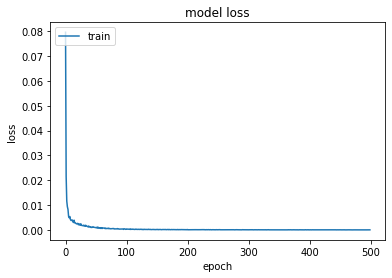

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

[413 rows x 16 columns]
<class 'pandas.core.frame.DataFrame'>
(413, 16)
(304, 110, 21)
(304, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 110, 128)          76800     
_________________________________________________________________
lstm_35 (LSTM)               (None, 110, 64)           49408     
_________________________________________________________________
lstm_36 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
304/304 [==============================] - 8s 26ms/step - loss: 0.1023
Epoch 2/500
304/304 [==============================] - 3s 9ms/step - loss: 0.0295
Epoch 

304/304 [==============================] - 3s 9ms/step - loss: 4.8951e-04
Epoch 87/500
304/304 [==============================] - 3s 9ms/step - loss: 7.9129e-04
Epoch 88/500
304/304 [==============================] - 3s 9ms/step - loss: 4.4955e-04
Epoch 89/500
304/304 [==============================] - 3s 9ms/step - loss: 3.6713e-04
Epoch 90/500
304/304 [==============================] - 3s 10ms/step - loss: 5.5466e-04
Epoch 91/500
304/304 [==============================] - 3s 9ms/step - loss: 4.6249e-04
Epoch 92/500
304/304 [==============================] - 3s 9ms/step - loss: 6.0184e-04
Epoch 93/500
304/304 [==============================] - 3s 9ms/step - loss: 4.4394e-04
Epoch 94/500
304/304 [==============================] - 3s 9ms/step - loss: 4.4262e-04
Epoch 95/500
304/304 [==============================] - 3s 9ms/step - loss: 5.7227e-04
Epoch 96/500
304/304 [==============================] - 3s 10ms/step - loss: 4.2797e-04
Epoch 97/500
304/304 [==============================] 

304/304 [==============================] - 3s 9ms/step - loss: 1.8619e-04
Epoch 180/500
304/304 [==============================] - 3s 10ms/step - loss: 2.4094e-04
Epoch 181/500
304/304 [==============================] - 3s 9ms/step - loss: 1.8471e-04
Epoch 182/500
304/304 [==============================] - 3s 9ms/step - loss: 1.6097e-04
Epoch 183/500
304/304 [==============================] - 3s 9ms/step - loss: 2.0167e-04
Epoch 184/500
304/304 [==============================] - 3s 9ms/step - loss: 2.1977e-04
Epoch 185/500
304/304 [==============================] - 3s 10ms/step - loss: 1.5389e-04
Epoch 186/500
304/304 [==============================] - 3s 9ms/step - loss: 1.3603e-04
Epoch 187/500
304/304 [==============================] - 3s 9ms/step - loss: 1.9137e-04
Epoch 188/500
304/304 [==============================] - 3s 9ms/step - loss: 2.1470e-04
Epoch 189/500
304/304 [==============================] - 3s 9ms/step - loss: 2.0015e-04
Epoch 190/500
304/304 [=====================

304/304 [==============================] - 3s 9ms/step - loss: 9.1258e-05
Epoch 273/500
304/304 [==============================] - 3s 9ms/step - loss: 1.5403e-04
Epoch 274/500
304/304 [==============================] - 3s 9ms/step - loss: 1.3267e-04
Epoch 275/500
304/304 [==============================] - 3s 10ms/step - loss: 7.7278e-05
Epoch 276/500
304/304 [==============================] - 3s 9ms/step - loss: 1.6274e-04
Epoch 277/500
304/304 [==============================] - 3s 9ms/step - loss: 1.1809e-04
Epoch 278/500
304/304 [==============================] - 3s 9ms/step - loss: 1.0566e-04
Epoch 279/500
304/304 [==============================] - 3s 9ms/step - loss: 1.1375e-04
Epoch 280/500
304/304 [==============================] - 3s 9ms/step - loss: 1.0593e-04
Epoch 281/500
304/304 [==============================] - 3s 10ms/step - loss: 1.5467e-04
Epoch 282/500
304/304 [==============================] - 3s 9ms/step - loss: 9.8640e-05
Epoch 283/500
304/304 [=====================

304/304 [==============================] - 3s 10ms/step - loss: 7.0951e-05
Epoch 366/500
304/304 [==============================] - 3s 9ms/step - loss: 9.1006e-05
Epoch 367/500
304/304 [==============================] - 3s 9ms/step - loss: 8.5484e-05
Epoch 368/500
304/304 [==============================] - 3s 9ms/step - loss: 8.6722e-05
Epoch 369/500
304/304 [==============================] - 3s 9ms/step - loss: 1.0297e-04
Epoch 370/500
304/304 [==============================] - 3s 10ms/step - loss: 5.2686e-05
Epoch 371/500
304/304 [==============================] - 3s 9ms/step - loss: 8.6019e-05
Epoch 372/500
304/304 [==============================] - 3s 9ms/step - loss: 1.2271e-04
Epoch 373/500
304/304 [==============================] - 3s 9ms/step - loss: 8.4513e-05
Epoch 374/500
304/304 [==============================] - 3s 9ms/step - loss: 7.1122e-05
Epoch 375/500
304/304 [==============================] - 3s 9ms/step - loss: 9.4311e-05
Epoch 376/500
304/304 [=====================

304/304 [==============================] - 3s 9ms/step - loss: 6.5923e-05
Epoch 459/500
304/304 [==============================] - 3s 9ms/step - loss: 7.0689e-05
Epoch 460/500
304/304 [==============================] - 3s 10ms/step - loss: 1.0389e-04
Epoch 461/500
304/304 [==============================] - 3s 9ms/step - loss: 5.6601e-05
Epoch 462/500
304/304 [==============================] - 3s 9ms/step - loss: 5.3669e-05
Epoch 463/500
304/304 [==============================] - 3s 9ms/step - loss: 7.6363e-05
Epoch 464/500
304/304 [==============================] - 3s 9ms/step - loss: 9.3617e-05
Epoch 465/500
304/304 [==============================] - 3s 10ms/step - loss: 6.2855e-05
Epoch 466/500
304/304 [==============================] - 3s 9ms/step - loss: 5.4046e-05
Epoch 467/500
304/304 [==============================] - 3s 9ms/step - loss: 8.1282e-05
Epoch 468/500
304/304 [==============================] - 3s 9ms/step - loss: 6.4978e-05
Epoch 469/500
304/304 [=====================

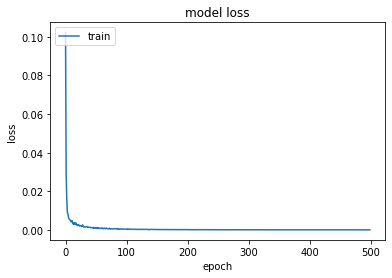

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

hand_z max is : 0.4099229762423224
hand_z min is : 0.05698730421795072
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
1    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
2    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
3    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
4    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
5    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
6    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
7    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
8    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
9    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
10   0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
11   0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 120, 128)          76800     
_________________________________________________________________
lstm_38 (LSTM)               (None, 120, 64)           49408     
_________________________________________________________________
lstm_39 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
314/314 [==============================] - 8s 27ms/step - loss: 0.0821
Epoch 2/500
314/314 [==============================] - 3s 10ms/step - loss: 0.0160
Epoch 3/500
314/314 [==============================] - 3s 10ms/step - loss: 0.0091
Epoch 4/500
314/314

314/314 [==============================] - 3s 10ms/step - loss: 6.8289e-04
Epoch 87/500
314/314 [==============================] - 3s 10ms/step - loss: 4.7310e-04
Epoch 88/500
314/314 [==============================] - 3s 10ms/step - loss: 5.5018e-04
Epoch 89/500
314/314 [==============================] - 3s 10ms/step - loss: 6.2563e-04
Epoch 90/500
314/314 [==============================] - 3s 10ms/step - loss: 4.9298e-04
Epoch 91/500
314/314 [==============================] - 3s 10ms/step - loss: 5.2107e-04
Epoch 92/500
314/314 [==============================] - 3s 10ms/step - loss: 5.3528e-04
Epoch 93/500
314/314 [==============================] - 3s 10ms/step - loss: 5.5662e-04
Epoch 94/500
314/314 [==============================] - 3s 10ms/step - loss: 3.9542e-04
Epoch 95/500
314/314 [==============================] - 3s 10ms/step - loss: 4.3698e-04
Epoch 96/500
314/314 [==============================] - 3s 10ms/step - loss: 7.2582e-04
Epoch 97/500
314/314 [=======================

314/314 [==============================] - 3s 10ms/step - loss: 2.3881e-04
Epoch 179/500
314/314 [==============================] - 3s 10ms/step - loss: 1.4034e-04
Epoch 180/500
314/314 [==============================] - 3s 10ms/step - loss: 2.1301e-04
Epoch 181/500
314/314 [==============================] - 3s 10ms/step - loss: 1.9122e-04
Epoch 182/500
314/314 [==============================] - 3s 10ms/step - loss: 2.2686e-04
Epoch 183/500
314/314 [==============================] - 3s 10ms/step - loss: 1.6065e-04
Epoch 184/500
314/314 [==============================] - 3s 10ms/step - loss: 2.2383e-04
Epoch 185/500
314/314 [==============================] - 3s 10ms/step - loss: 2.1291e-04
Epoch 186/500
314/314 [==============================] - 3s 10ms/step - loss: 1.5887e-04
Epoch 187/500
314/314 [==============================] - 3s 10ms/step - loss: 2.2179e-04
Epoch 188/500
314/314 [==============================] - 3s 10ms/step - loss: 1.8000e-04
Epoch 189/500
314/314 [============

314/314 [==============================] - 3s 10ms/step - loss: 1.1648e-04
Epoch 271/500
314/314 [==============================] - 3s 10ms/step - loss: 1.0116e-04
Epoch 272/500
314/314 [==============================] - 3s 10ms/step - loss: 1.5206e-04
Epoch 273/500
314/314 [==============================] - 3s 10ms/step - loss: 1.3006e-04
Epoch 274/500
314/314 [==============================] - 3s 10ms/step - loss: 1.3689e-04
Epoch 275/500
314/314 [==============================] - 3s 10ms/step - loss: 1.2688e-04
Epoch 276/500
314/314 [==============================] - 3s 10ms/step - loss: 9.8273e-05
Epoch 277/500
314/314 [==============================] - 3s 10ms/step - loss: 1.2546e-04
Epoch 278/500
314/314 [==============================] - 3s 10ms/step - loss: 1.2864e-04
Epoch 279/500
314/314 [==============================] - 3s 10ms/step - loss: 1.3489e-04
Epoch 280/500
314/314 [==============================] - 3s 10ms/step - loss: 1.2823e-04
Epoch 281/500
314/314 [============

314/314 [==============================] - 3s 10ms/step - loss: 7.8909e-05
Epoch 363/500
314/314 [==============================] - 3s 10ms/step - loss: 9.0122e-05
Epoch 364/500
314/314 [==============================] - 3s 10ms/step - loss: 1.0354e-04
Epoch 365/500
314/314 [==============================] - 3s 10ms/step - loss: 9.3766e-05
Epoch 366/500
314/314 [==============================] - 3s 10ms/step - loss: 7.9756e-05
Epoch 367/500
314/314 [==============================] - 3s 10ms/step - loss: 1.1367e-04
Epoch 368/500
314/314 [==============================] - 3s 10ms/step - loss: 1.0959e-04
Epoch 369/500
314/314 [==============================] - 3s 10ms/step - loss: 7.2318e-05
Epoch 370/500
314/314 [==============================] - 3s 10ms/step - loss: 1.0311e-04
Epoch 371/500
314/314 [==============================] - 3s 10ms/step - loss: 6.5671e-05
Epoch 372/500
314/314 [==============================] - 3s 10ms/step - loss: 1.0878e-04
Epoch 373/500
314/314 [============

314/314 [==============================] - 3s 10ms/step - loss: 5.0814e-05
Epoch 455/500
314/314 [==============================] - 3s 10ms/step - loss: 7.8318e-05
Epoch 456/500
314/314 [==============================] - 3s 10ms/step - loss: 9.2370e-05
Epoch 457/500
314/314 [==============================] - 3s 10ms/step - loss: 9.1201e-05
Epoch 458/500
314/314 [==============================] - 3s 10ms/step - loss: 6.1185e-05
Epoch 459/500
314/314 [==============================] - 3s 10ms/step - loss: 7.0554e-05
Epoch 460/500
314/314 [==============================] - 3s 10ms/step - loss: 6.6521e-05
Epoch 461/500
314/314 [==============================] - 3s 10ms/step - loss: 6.9782e-05
Epoch 462/500
314/314 [==============================] - 3s 10ms/step - loss: 8.9667e-05
Epoch 463/500
314/314 [==============================] - 3s 10ms/step - loss: 5.7341e-05
Epoch 464/500
314/314 [==============================] - 3s 10ms/step - loss: 7.4466e-05
Epoch 465/500
314/314 [============

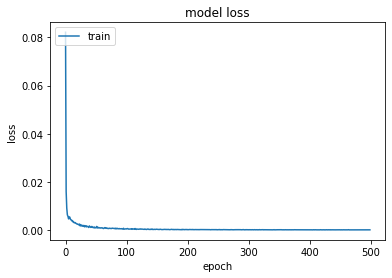

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

hand_z max is : 0.4099229762423224
hand_z min is : 0.05698730421795072
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
1    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
2    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
3    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
4    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
5    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
6    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
7    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
8    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
9    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
10   0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
11   0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 130, 128)          76800     
_________________________________________________________________
lstm_41 (LSTM)               (None, 130, 64)           49408     
_________________________________________________________________
lstm_42 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
324/324 [==============================] - 10s 31ms/step - loss: 0.1158
Epoch 2/500
324/324 [==============================] - 4s 13ms/step - loss: 0.0189
Epoch 3/500
324/324 [==============================] - 4s 12ms/step - loss: 0.0160
Epoch 4/500
324/32

324/324 [==============================] - 4s 12ms/step - loss: 5.6124e-04
Epoch 87/500
324/324 [==============================] - 4s 13ms/step - loss: 6.6562e-04
Epoch 88/500
324/324 [==============================] - 4s 12ms/step - loss: 4.6673e-04
Epoch 89/500
324/324 [==============================] - 4s 13ms/step - loss: 5.6535e-04
Epoch 90/500
324/324 [==============================] - 4s 13ms/step - loss: 4.4079e-04
Epoch 91/500
324/324 [==============================] - 4s 13ms/step - loss: 7.9710e-04
Epoch 92/500
324/324 [==============================] - 4s 12ms/step - loss: 6.3960e-04
Epoch 93/500
324/324 [==============================] - 4s 13ms/step - loss: 4.2174e-04
Epoch 94/500
324/324 [==============================] - 4s 13ms/step - loss: 3.9296e-04
Epoch 95/500
324/324 [==============================] - 4s 13ms/step - loss: 4.1852e-04
Epoch 96/500
324/324 [==============================] - 4s 12ms/step - loss: 4.3471e-04
Epoch 97/500
324/324 [=======================

324/324 [==============================] - 4s 13ms/step - loss: 1.8495e-04
Epoch 179/500
324/324 [==============================] - 4s 13ms/step - loss: 2.0957e-04
Epoch 180/500
324/324 [==============================] - 4s 13ms/step - loss: 2.0170e-04
Epoch 181/500
324/324 [==============================] - 4s 13ms/step - loss: 1.4725e-04
Epoch 182/500
324/324 [==============================] - 4s 12ms/step - loss: 1.4530e-04
Epoch 183/500
324/324 [==============================] - 4s 12ms/step - loss: 1.9412e-04
Epoch 184/500
324/324 [==============================] - 4s 12ms/step - loss: 1.2805e-04
Epoch 185/500
324/324 [==============================] - 4s 13ms/step - loss: 1.8060e-04
Epoch 186/500
324/324 [==============================] - 4s 13ms/step - loss: 1.5388e-04
Epoch 187/500
324/324 [==============================] - 4s 12ms/step - loss: 2.8099e-04
Epoch 188/500
324/324 [==============================] - 4s 12ms/step - loss: 1.5559e-04
Epoch 189/500
324/324 [============

324/324 [==============================] - 4s 12ms/step - loss: 7.9242e-05
Epoch 271/500
324/324 [==============================] - 4s 13ms/step - loss: 1.2380e-04
Epoch 272/500
324/324 [==============================] - 4s 13ms/step - loss: 1.0647e-04
Epoch 273/500
324/324 [==============================] - 4s 12ms/step - loss: 1.1739e-04
Epoch 274/500
324/324 [==============================] - 4s 12ms/step - loss: 8.9834e-05
Epoch 275/500
324/324 [==============================] - 4s 13ms/step - loss: 1.1714e-04
Epoch 276/500
324/324 [==============================] - 4s 13ms/step - loss: 1.3400e-04
Epoch 277/500
324/324 [==============================] - 4s 12ms/step - loss: 8.2786e-05
Epoch 278/500
324/324 [==============================] - 4s 13ms/step - loss: 1.0937e-04
Epoch 279/500
324/324 [==============================] - 4s 13ms/step - loss: 9.6782e-05
Epoch 280/500
324/324 [==============================] - 4s 12ms/step - loss: 1.2297e-04
Epoch 281/500
324/324 [============

324/324 [==============================] - 4s 12ms/step - loss: 9.4957e-05
Epoch 363/500
324/324 [==============================] - 4s 13ms/step - loss: 7.4945e-05
Epoch 364/500
324/324 [==============================] - 4s 13ms/step - loss: 1.0585e-04
Epoch 365/500
324/324 [==============================] - 4s 13ms/step - loss: 7.2522e-05
Epoch 366/500
324/324 [==============================] - 4s 13ms/step - loss: 6.6636e-05
Epoch 367/500
324/324 [==============================] - 4s 13ms/step - loss: 6.8189e-05
Epoch 368/500
324/324 [==============================] - 4s 13ms/step - loss: 9.0264e-05
Epoch 369/500
324/324 [==============================] - 4s 13ms/step - loss: 8.5504e-05
Epoch 370/500
324/324 [==============================] - 4s 12ms/step - loss: 7.4067e-05
Epoch 371/500
324/324 [==============================] - 4s 13ms/step - loss: 8.8182e-05
Epoch 372/500
324/324 [==============================] - 4s 13ms/step - loss: 7.0727e-05
Epoch 373/500
324/324 [============

324/324 [==============================] - 4s 13ms/step - loss: 5.6632e-05
Epoch 455/500
324/324 [==============================] - 4s 13ms/step - loss: 6.3940e-05
Epoch 456/500
324/324 [==============================] - 4s 12ms/step - loss: 4.9068e-05
Epoch 457/500
324/324 [==============================] - 4s 12ms/step - loss: 7.6720e-05
Epoch 458/500
324/324 [==============================] - 4s 13ms/step - loss: 6.8814e-05
Epoch 459/500
324/324 [==============================] - 4s 13ms/step - loss: 4.5479e-05
Epoch 460/500
324/324 [==============================] - 4s 12ms/step - loss: 6.7025e-05
Epoch 461/500
324/324 [==============================] - 4s 12ms/step - loss: 6.0527e-05
Epoch 462/500
324/324 [==============================] - 4s 12ms/step - loss: 6.9179e-05
Epoch 463/500
324/324 [==============================] - 4s 13ms/step - loss: 6.3065e-05
Epoch 464/500
324/324 [==============================] - 4s 13ms/step - loss: 6.9353e-05
Epoch 465/500
324/324 [============

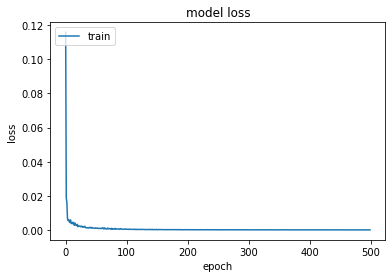

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

[473 rows x 38 columns]
~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~
hand_x max is : 0.9543508660329038
hand_x min is : 0.7421045083853685
hand_y max is : 1.0723921155088898
hand_y min is : 0.7792901679254952
hand_z max is : 0.4099229762423224
hand_z min is : 0.05698730421795072
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
1    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
2    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
3    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
4    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
5    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
6    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
7    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
8    0.749999  0.499999    0.50000 -7.360130e-07   0.50000 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 140, 128)          76800     
_________________________________________________________________
lstm_44 (LSTM)               (None, 140, 64)           49408     
_________________________________________________________________
lstm_45 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
334/334 [==============================] - 10s 31ms/step - loss: 0.0850
Epoch 2/500
334/334 [==============================] - 4s 13ms/step - loss: 0.0151
Epoch 3/500
334/334 [==============================] - 5s 14ms/step - loss: 0.0112
Epoch 4/500
334/33

334/334 [==============================] - 4s 13ms/step - loss: 5.5918e-04
Epoch 87/500
334/334 [==============================] - 4s 13ms/step - loss: 4.3657e-04
Epoch 88/500
334/334 [==============================] - 5s 14ms/step - loss: 5.4441e-04
Epoch 89/500
334/334 [==============================] - 4s 13ms/step - loss: 3.7402e-04
Epoch 90/500
334/334 [==============================] - 4s 13ms/step - loss: 5.8784e-04
Epoch 91/500
334/334 [==============================] - 5s 14ms/step - loss: 4.7387e-04
Epoch 92/500
334/334 [==============================] - 5s 14ms/step - loss: 5.3523e-04
Epoch 93/500
334/334 [==============================] - 4s 13ms/step - loss: 2.9023e-04
Epoch 94/500
334/334 [==============================] - 4s 13ms/step - loss: 5.4151e-04
Epoch 95/500
334/334 [==============================] - 5s 14ms/step - loss: 3.5447e-04
Epoch 96/500
334/334 [==============================] - 4s 13ms/step - loss: 4.7037e-04
Epoch 97/500
334/334 [=======================

334/334 [==============================] - 4s 13ms/step - loss: 1.7669e-04
Epoch 179/500
334/334 [==============================] - 4s 13ms/step - loss: 2.2674e-04
Epoch 180/500
334/334 [==============================] - 5s 14ms/step - loss: 1.5529e-04
Epoch 181/500
334/334 [==============================] - 4s 13ms/step - loss: 1.7749e-04
Epoch 182/500
334/334 [==============================] - 5s 14ms/step - loss: 1.4199e-04
Epoch 183/500
334/334 [==============================] - 4s 13ms/step - loss: 2.4002e-04
Epoch 184/500
334/334 [==============================] - 5s 14ms/step - loss: 1.7970e-04
Epoch 185/500
334/334 [==============================] - 4s 13ms/step - loss: 1.6231e-04
Epoch 186/500
334/334 [==============================] - 4s 13ms/step - loss: 1.9890e-04
Epoch 187/500
334/334 [==============================] - 5s 14ms/step - loss: 1.3910e-04
Epoch 188/500
334/334 [==============================] - 4s 13ms/step - loss: 1.6551e-04
Epoch 189/500
334/334 [============

334/334 [==============================] - 4s 13ms/step - loss: 1.0388e-04
Epoch 271/500
334/334 [==============================] - 4s 13ms/step - loss: 1.1900e-04
Epoch 272/500
334/334 [==============================] - 4s 13ms/step - loss: 1.4161e-04
Epoch 273/500
334/334 [==============================] - 5s 14ms/step - loss: 1.3090e-04
Epoch 274/500
334/334 [==============================] - 4s 13ms/step - loss: 8.8706e-05
Epoch 275/500
334/334 [==============================] - 4s 13ms/step - loss: 1.1066e-04
Epoch 276/500
334/334 [==============================] - 5s 14ms/step - loss: 1.1692e-04
Epoch 277/500
334/334 [==============================] - 4s 13ms/step - loss: 1.2171e-04
Epoch 278/500
334/334 [==============================] - 4s 13ms/step - loss: 9.0035e-05
Epoch 279/500
334/334 [==============================] - 4s 13ms/step - loss: 1.1413e-04
Epoch 280/500
334/334 [==============================] - 5s 14ms/step - loss: 1.2256e-04
Epoch 281/500
334/334 [============

334/334 [==============================] - 4s 13ms/step - loss: 1.0552e-04
Epoch 363/500
334/334 [==============================] - 4s 13ms/step - loss: 7.4944e-05
Epoch 364/500
334/334 [==============================] - 4s 13ms/step - loss: 9.8519e-05
Epoch 365/500
334/334 [==============================] - 5s 14ms/step - loss: 7.4635e-05
Epoch 366/500
334/334 [==============================] - 4s 13ms/step - loss: 8.8875e-05
Epoch 367/500
334/334 [==============================] - 4s 13ms/step - loss: 1.1019e-04
Epoch 368/500
334/334 [==============================] - 4s 13ms/step - loss: 6.1543e-05
Epoch 369/500
334/334 [==============================] - 5s 14ms/step - loss: 8.8377e-05
Epoch 370/500
334/334 [==============================] - 4s 13ms/step - loss: 8.9942e-05
Epoch 371/500
334/334 [==============================] - 4s 13ms/step - loss: 1.1069e-04
Epoch 372/500
334/334 [==============================] - 5s 14ms/step - loss: 7.4004e-05
Epoch 373/500
334/334 [============

334/334 [==============================] - 5s 14ms/step - loss: 7.9616e-05
Epoch 455/500
334/334 [==============================] - 4s 13ms/step - loss: 8.6911e-05
Epoch 456/500
334/334 [==============================] - 4s 13ms/step - loss: 6.0339e-05
Epoch 457/500
334/334 [==============================] - 5s 14ms/step - loss: 7.6231e-05
Epoch 458/500
334/334 [==============================] - 5s 14ms/step - loss: 7.5224e-05
Epoch 459/500
334/334 [==============================] - 4s 13ms/step - loss: 6.6402e-05
Epoch 460/500
334/334 [==============================] - 4s 13ms/step - loss: 7.1549e-05
Epoch 461/500
334/334 [==============================] - 5s 14ms/step - loss: 6.7831e-05
Epoch 462/500
334/334 [==============================] - 4s 13ms/step - loss: 6.4607e-05
Epoch 463/500
334/334 [==============================] - 4s 13ms/step - loss: 7.8513e-05
Epoch 464/500
334/334 [==============================] - 4s 13ms/step - loss: 6.7738e-05
Epoch 465/500
334/334 [============

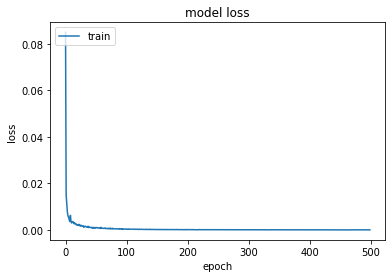

datasets_full_trag/actions/4_actions.csv
datasets_full_trag/obs/4_obs.csv
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999   0.500000 -7.360130e-07  0.500000  0.500009   
1    0.743188  0.498898   0.497298  2.086508e-02  0.506050  0.502049   
2    0.738896  0.498234   0.498029  4.043882e-02  0.507110  0.501205   
3    0.731550  0.496087   0.499214  7.228328e-02  0.511075  0.497778   
4    0.723588  0.492373   0.499265  1.041272e-01  0.513335  0.497890   
5    0.715626  0.488272   0.501204  1.359711e-01  0.510645  0.498476   
6    0.707664  0.483874   0.502317  1.678153e-01  0.504823  0.498421   
7    0.699701  0.481272   0.502112  1.996598e-01  0.497211  0.502053   
8    0.691739  0.479884   0.504707  2.315041e-01  0.490559  0.510600   
9    0.683777  0.477078   0.506213  2.633484e-01  0.484444  0.517854   
10   0.675815  0.473275   0.506732  2.951925e-01  0.479868  0.523654   
11   0.667853  0.468928   0.505981  3.270366e-01  0.477417  0.

[493 rows x 38 columns]
~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~
hand_x max is : 0.9543508660329038
hand_x min is : 0.7421045083853685
hand_y max is : 1.0723921155088898
hand_y min is : 0.7792901679254952
hand_z max is : 0.4099229762423224
hand_z min is : 0.05698730421795072
      arm_one   arm_two  arm_three      arm_four  arm_five   arm_six  \
0    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
1    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
2    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
3    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
4    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
5    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
6    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
7    0.749999  0.499999    0.50000 -7.360130e-07   0.50000  0.500009   
8    0.749999  0.499999    0.50000 -7.360130e-07   0.50000 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 150, 128)          76800     
_________________________________________________________________
lstm_47 (LSTM)               (None, 150, 64)           49408     
_________________________________________________________________
lstm_48 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
Total params: 139,152
Trainable params: 139,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
344/344 [==============================] - 11s 33ms/step - loss: 0.0806
Epoch 2/500
344/344 [==============================] - 5s 14ms/step - loss: 0.0136
Epoch 3/500
344/344 [==============================] - 5s 14ms/step - loss: 0.0071
Epoch 4/500
344/34

344/344 [==============================] - 5s 14ms/step - loss: 3.3445e-04
Epoch 87/500
344/344 [==============================] - 5s 14ms/step - loss: 3.5035e-04
Epoch 88/500
344/344 [==============================] - 5s 14ms/step - loss: 3.6322e-04
Epoch 89/500
344/344 [==============================] - 5s 14ms/step - loss: 3.7304e-04
Epoch 90/500
344/344 [==============================] - 5s 14ms/step - loss: 2.2887e-04
Epoch 91/500
344/344 [==============================] - 5s 14ms/step - loss: 4.0205e-04
Epoch 92/500
344/344 [==============================] - 5s 14ms/step - loss: 2.7587e-04
Epoch 93/500
344/344 [==============================] - 5s 14ms/step - loss: 2.6321e-04
Epoch 94/500
344/344 [==============================] - 5s 14ms/step - loss: 2.3623e-04
Epoch 95/500
344/344 [==============================] - 5s 14ms/step - loss: 3.2151e-04
Epoch 96/500
344/344 [==============================] - 5s 14ms/step - loss: 3.2157e-04
Epoch 97/500
344/344 [=======================

344/344 [==============================] - 5s 14ms/step - loss: 1.1153e-04
Epoch 179/500
344/344 [==============================] - 5s 14ms/step - loss: 1.1575e-04
Epoch 180/500
344/344 [==============================] - 5s 14ms/step - loss: 9.7431e-05
Epoch 181/500
344/344 [==============================] - 5s 14ms/step - loss: 1.6116e-04
Epoch 182/500
344/344 [==============================] - 5s 14ms/step - loss: 8.3012e-05
Epoch 183/500
344/344 [==============================] - 5s 14ms/step - loss: 7.4986e-05
Epoch 184/500
344/344 [==============================] - 5s 14ms/step - loss: 1.3337e-04
Epoch 185/500
344/344 [==============================] - 5s 14ms/step - loss: 1.4610e-04
Epoch 186/500
344/344 [==============================] - 4s 13ms/step - loss: 8.0422e-05
Epoch 187/500
344/344 [==============================] - 5s 14ms/step - loss: 1.0393e-04
Epoch 188/500
344/344 [==============================] - 5s 14ms/step - loss: 8.5585e-05
Epoch 189/500
344/344 [============

344/344 [==============================] - 5s 14ms/step - loss: 6.5923e-05
Epoch 271/500
344/344 [==============================] - 5s 14ms/step - loss: 7.3187e-05
Epoch 272/500
344/344 [==============================] - 5s 14ms/step - loss: 6.7712e-05
Epoch 273/500
344/344 [==============================] - 5s 14ms/step - loss: 7.7258e-05
Epoch 274/500
344/344 [==============================] - 5s 14ms/step - loss: 4.9694e-05
Epoch 275/500
344/344 [==============================] - 5s 14ms/step - loss: 8.5894e-05
Epoch 276/500
344/344 [==============================] - 5s 14ms/step - loss: 5.7123e-05
Epoch 277/500
344/344 [==============================] - 5s 14ms/step - loss: 9.6501e-05
Epoch 278/500
344/344 [==============================] - 5s 14ms/step - loss: 5.8417e-05
Epoch 279/500
344/344 [==============================] - 5s 14ms/step - loss: 7.1529e-05
Epoch 280/500
344/344 [==============================] - 5s 14ms/step - loss: 7.2505e-05
Epoch 281/500
344/344 [============

344/344 [==============================] - 5s 14ms/step - loss: 6.1404e-05
Epoch 363/500
344/344 [==============================] - 5s 14ms/step - loss: 3.5620e-05
Epoch 364/500
344/344 [==============================] - 5s 14ms/step - loss: 5.5250e-05
Epoch 365/500
344/344 [==============================] - 5s 14ms/step - loss: 6.3860e-05
Epoch 366/500
344/344 [==============================] - 5s 14ms/step - loss: 3.6250e-05
Epoch 367/500
344/344 [==============================] - 5s 14ms/step - loss: 4.5313e-05
Epoch 368/500
344/344 [==============================] - 5s 14ms/step - loss: 7.2064e-05
Epoch 369/500
344/344 [==============================] - 5s 14ms/step - loss: 3.2847e-05
Epoch 370/500
344/344 [==============================] - 5s 14ms/step - loss: 5.5261e-05
Epoch 371/500
344/344 [==============================] - 5s 14ms/step - loss: 5.3444e-05
Epoch 372/500
344/344 [==============================] - 5s 14ms/step - loss: 5.2876e-05
Epoch 373/500
344/344 [============

344/344 [==============================] - 5s 14ms/step - loss: 5.7712e-05
Epoch 455/500
344/344 [==============================] - 5s 14ms/step - loss: 2.9685e-05
Epoch 456/500
344/344 [==============================] - 5s 14ms/step - loss: 4.3370e-05
Epoch 457/500
344/344 [==============================] - 5s 14ms/step - loss: 5.0699e-05
Epoch 458/500
344/344 [==============================] - 5s 14ms/step - loss: 3.8745e-05
Epoch 459/500
344/344 [==============================] - 5s 14ms/step - loss: 4.8341e-05
Epoch 460/500
344/344 [==============================] - 5s 14ms/step - loss: 4.2838e-05
Epoch 461/500
344/344 [==============================] - 5s 14ms/step - loss: 3.4888e-05
Epoch 462/500
344/344 [==============================] - 5s 14ms/step - loss: 4.5754e-05
Epoch 463/500
344/344 [==============================] - 5s 14ms/step - loss: 4.2359e-05
Epoch 464/500
344/344 [==============================] - 5s 14ms/step - loss: 4.2411e-05
Epoch 465/500
344/344 [============

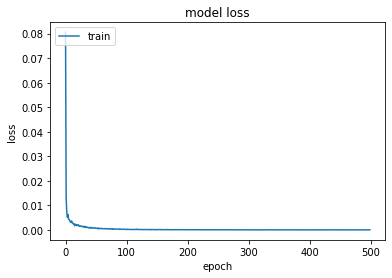

training done


In [3]:
# ####################single training single dataset####################################
if __name__ == '__main__':
    
    
    all_filenames = []
    trag_pos = 4
#     timesteps = 5
    experiment_index = 0
    
    while(experiment_index < 16):
        if(experiment_index == 0):
            timesteps = 5
        elif(experiment_index == 1):
            timesteps = 10
        elif(experiment_index == 2):
            timesteps = 20
        elif(experiment_index == 3):
            timesteps = 30
        elif(experiment_index == 4):
            timesteps = 40
        elif(experiment_index == 5):
            timesteps = 50
        elif(experiment_index == 6):
            timesteps = 60
        elif(experiment_index == 7):
            timesteps = 70
        elif(experiment_index == 8):
            timesteps = 80
        elif(experiment_index == 9):
            timesteps = 90
        elif(experiment_index == 10):
            timesteps = 100
        elif(experiment_index == 11):
            timesteps = 110
        elif(experiment_index == 12):
            timesteps = 120
        elif(experiment_index == 13):
            timesteps = 130
        elif(experiment_index == 14):
            timesteps = 140
        elif(experiment_index == 15):
            timesteps = 150
            
        experiment_index = experiment_index + 1
        
        
        filename = "datasets_full_trag/npz/Lstm-syn-dataset-fulltrag-addcoke/Lstm4_position.npz"
        data = np.load(filename)
        actions_val = None
        obs_val = None

        for key, value in data.items():
            if(key == "actions"):
                actions_val = value
            elif(key == "obs"):
                obs_val = value

        action_path = generate_csv(actions_val, "actions", "datasets_full_trag/actions/4_actions.csv")
        obs_path = generate_csv(obs_val, "obs", "datasets_full_trag/obs/4_obs.csv")
        print(action_path)
        print(obs_path)
        merge_csv(obs_path, action_path, "datasets_full_trag/merge/4_dataset.csv")
        train = readTrain("datasets_full_trag/merge/4_dataset.csv")
        

        #augment data
        aug_train = augDataRow(train, timesteps)
        print("~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~")

        # Normalization
        train_norm = normalize(aug_train)
        print(train_norm)
        print("~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~")

        X_train, Y_train = buildTrain_v2(train_norm, timesteps)


        print(X_train.shape)
        print(Y_train.shape)
        ### shuffle the data, and random seed is 10
#         X_train, Y_train = shuffle(X_train, Y_train)

    # # # #     # split training data and validation data
    # # # #     X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.2)


#         model = buildManyToOneModel(X_train)
#         model = buildManyToOneModel_expand_width(X_train)
        model = buildManyToOneModel_expand_depth_dropout(X_train)
    
#         model.fit(X_train, Y_train, epochs=500, batch_size=64)
        callback = EarlyStopping(monitor="loss", patience=40, verbose=1, mode="auto")
        history = model.fit(X_train, Y_train, epochs=500, batch_size=64)
        model.summary()
#         history = model.fit(X_train, Y_train, epochs=500, batch_size=64)

    
        plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper left')
        plt.legend(['train'], loc='upper left')

#         save_lossPic_path = "model_expand_depth/full_trag/512_256_64_ver/batch_size_128/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
#         save_lossPic_path = "model_expand_width/full_trag/1024_256_ver/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
#         save_lossPic_path = "model/full_trag/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"
        save_lossPic_path = "model_expand_depth/full_trag/single_position/dropout_test/128_64_32_ver/batch_size_64/Loss/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".png"  
        plt.savefig(save_lossPic_path)
        
        plt.show()

#         save_path = "model_expand_depth/full_trag/512_256_64_ver/batch_size_128/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
#         save_path = "model_expand_width/full_trag/1024_256_ver/batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
#         save_path = "model/full_trag//batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"
        save_path = "model_expand_depth/full_trag/single_position/dropout_test/128_64_32_ver/batch_size_64/" + str(trag_pos) + "_LstmFullTrag_" + str(timesteps) + ".h5"  

        model.save(save_path)  # creates a HDF5 file

    
        del model
    
    print("training done")



In [4]:
    #         callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
    # # # model.fit(X_train, Y_train, epochs=200, batch_size=32, callbacks=[callback])
    # # # model.fit(X_train, Y_train, epochs=200, batch_size=16, validation_data=(X_val, Y_val), callbacks=[callback])


In [5]:
# ###################single training many dataset####################################

# if __name__ == '__main__':
    
    
#     experiment_index = 0
    
#     while(experiment_index < 16):
#         if(experiment_index == 0):
#             timesteps = 5
#         elif(experiment_index == 1):
#             timesteps = 10
#         elif(experiment_index == 2):
#             timesteps = 20
#         elif(experiment_index == 3):
#             timesteps = 30
#         elif(experiment_index == 4):
#             timesteps = 40
#         elif(experiment_index == 5):
#             timesteps = 50
#         elif(experiment_index == 6):
#             timesteps = 60
#         elif(experiment_index == 7):
#             timesteps = 70
#         elif(experiment_index == 8):
#             timesteps = 80
#         elif(experiment_index == 9):
#             timesteps = 90
#         elif(experiment_index == 10):
#             timesteps = 100
#         elif(experiment_index == 11):
#             timesteps = 110
#         elif(experiment_index == 12):
#             timesteps = 120
#         elif(experiment_index == 13):
#             timesteps = 130
#         elif(experiment_index == 14):
#             timesteps = 140
#         elif(experiment_index == 15):
#             timesteps = 150
            
#         experiment_index = experiment_index + 1
        
        
#         filename_0 = "datasets_full_trag/merge/0_dataset.csv"
#         filename_1 = "datasets_full_trag/merge/1_dataset.csv"
#         filename_2 = "datasets_full_trag/merge/2_dataset.csv"
        
#         train0 = readTrain(filename_0)
#         train1 = readTrain(filename_1)
#         train2 = readTrain(filename_2)
        

#         #augment data
#         aug_train0 = augDataRow(train0, timesteps)
#         aug_train1 = augDataRow(train1, timesteps)
#         aug_train2 = augDataRow(train2, timesteps)
#         print("~~~~~~~~~~~~~~~~~~augmented finish~~~~~~~~~~~~~~~~~~~~~~~")

#         hand_pos(aug_train0)
#         hand_pos(aug_train1)
#         hand_pos(aug_train2)
    
#     #     Normalization
#         train_0_norm = many_normalize(aug_train0)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         train_1_norm = many_normalize(aug_train1)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         train_2_norm = many_normalize(aug_train2)
        
#         print("~~~~~~~~~~~~~~~~~~normalize finish~~~~~~~~~~~~~~~~~~~~~~~")

    
#         X0_train, Y0_train = buildTrain_v2(train_0_norm, timesteps)
#         X1_train, Y1_train = buildTrain_v2(train_1_norm, timesteps)
#         X2_train, Y2_train = buildTrain_v2(train_2_norm, timesteps)
        
        
            
#         print(type(X0_train))
#         print(X0_train.shape)
#         print(type(Y0_train))
#         print(Y0_train.shape)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print(type(X1_train))
#         print(X1_train.shape)
#         print(type(Y1_train))
#         print(Y1_train.shape)
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print(type(X2_train))
#         print(X2_train.shape)
#         print(type(Y2_train))
#         print(Y2_train.shape)
    
#         X_train = np.concatenate((X0_train, X1_train), axis = 0)
#         X_train = np.concatenate((X_train, X2_train), axis = 0)

#         Y_train = np.concatenate((Y0_train, Y1_train), axis = 0)
#         Y_train = np.concatenate((Y_train, Y2_train), axis = 0)


#         print(X_train.shape)
#         print(Y_train.shape)
       


#         model = buildManyToOneModel_expand_depth_dropout(X_train)
    
#         callback = EarlyStopping(monitor="loss", patience=30, verbose=1, mode="auto")
# #         history = model.fit(X_train, Y_train, epochs=500, batch_size=128, callbacks=[callback])
#         history = model.fit(X_train, Y_train, epochs=500, batch_size=64)

    
#         plt.plot(history.history['loss'])
#         plt.title('model loss')
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train'], loc='upper left')
        
#         trag_pos = "012"
        
#         save_lossPic_path = "model_expand_depth/full_trag/many_position/dropout_test/128_64_32_ver/batch_size_64/Loss/" + trag_pos + "_LstmFullTrag_" + str(timesteps) + ".png"  
#         plt.savefig(save_lossPic_path)
#         plt.show()

#         save_path = "model_expand_depth/full_trag/many_position/dropout_test/128_64_32_ver/batch_size_64/" + trag_pos + "_LstmFullTrag_" + str(timesteps) + ".h5"  
#         model.save(save_path)  # creates a HDF5 file

    
#         del model
    
#     print("training done")
    
    
